# This is a newer version of SincNet with updated Loading and training functions

In [1]:
import os
import librosa 
import librosa.display
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import math

import sys

import numpy as np
import matplotlib.pyplot as plt


import tqdm


/home/nlpt4239/miniconda3/envs/SincNet/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [2]:
Desired_cuda_device_number = 1

print("Selecting Cuda device... \t\t", end="")
if torch.cuda.is_available(): # we'll use cuda
    device = "cuda:"+str(Desired_cuda_device_number)
    torch.cuda.set_device(device)
    if(torch.cuda.current_device() == Desired_cuda_device_number and torch.cuda.is_available()):
        print("Cuda was selected successfully!")
    else:
        print("Cuda was not selected successfully...")
else:
    print("Cuda device(s) is(are) not available.")

Selecting Cuda device... 		Cuda was selected successfully!


## The different networks are defined below:

### Functions and Classes that are used by the authors in speaker_it.py

In [3]:
## Function That I was Talking about, used in SincNet
def flip(x, dim):
    xsize = x.size()
    dim = x.dim() + dim if dim < 0 else dim
    x = x.contiguous()
    x = x.view(-1, *xsize[dim:])
    x = x.view(x.size(0), x.size(1), -1)[:, getattr(torch.arange(x.size(1)-1, 
                      -1, -1), ('cpu','cuda')[x.is_cuda])().long(), :]
    return x.view(xsize)
    

    
## Function that converts dictionary values to nn functions
def act_fun(act_type):

 if act_type=="relu":
    return nn.ReLU()
            
 if act_type=="tanh":
    return nn.Tanh()
            
 if act_type=="sigmoid":
    return nn.Sigmoid()
           
 if act_type=="leaky_relu":
    return nn.LeakyReLU(0.2)
            
 if act_type=="elu":
    return nn.ELU()
                     
 if act_type=="softmax":
    return nn.LogSoftmax(dim=1)
        
 if act_type=="linear":
    return nn.LeakyReLU(1) # initializzed like this, but not used in forward!
 
 ## Added SeLu and PReLu   
 if act_type=="selu":
    return nn.SELU()
 
 if act_type=="prelu":
    return nn.PReLU(init=0.2) #Initial value of alpha is 0.2 like in LeakyReLu above

            
## Layer that normalizes input in SincNet and MLP
class LayerNorm(nn.Module):

    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    ## Normalizes the info
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

    
    
## MLP Generic Class
class MLP(nn.Module):
    def __init__(self, options):
        super(MLP, self).__init__()
        
        self.input_dim=int(options['input_dim'])
        self.fc_lay=options['fc_lay']
        self.fc_drop=options['fc_drop']
        self.fc_use_batchnorm=options['fc_use_batchnorm']
        self.fc_use_laynorm=options['fc_use_laynorm']
        self.fc_use_laynorm_inp=options['fc_use_laynorm_inp']
        self.fc_use_batchnorm_inp=options['fc_use_batchnorm_inp']
        
        ## Activation functions given by the .cfg file under [dnn]
        self.fc_act=options['fc_act']
        
       
        self.wx  = nn.ModuleList([])
        self.bn  = nn.ModuleList([])
        self.ln  = nn.ModuleList([])
        self.act = nn.ModuleList([])
        self.drop = nn.ModuleList([])
       

       
        # input layer normalization
        if self.fc_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
          
        # input batch normalization    
        if self.fc_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
           
        self.N_fc_lay=len(self.fc_lay)
             
        current_input=self.input_dim
        
        # Initialization of hidden layers
        
        for i in range(self.N_fc_lay):
            
         # dropout
         self.drop.append(nn.Dropout(p=self.fc_drop[i]))
         
         ## First MLP is leaky_relu,leaky_relu,leaky_relu
         ## Second is softmax
         # activation
         self.act.append(act_fun(self.fc_act[i]))
         
         
         add_bias=True
         
         # layer norm initialization
         self.ln.append(LayerNorm(self.fc_lay[i]))
         self.bn.append(nn.BatchNorm1d(self.fc_lay[i],momentum=0.05))
         
         if self.fc_use_laynorm[i] or self.fc_use_batchnorm[i]:
             add_bias=False
         
              
         # Linear operations
         self.wx.append(nn.Linear(current_input, self.fc_lay[i],bias=add_bias))
         
         # weight initialization
         self.wx[i].weight = torch.nn.Parameter(torch.Tensor(self.fc_lay[i],current_input).uniform_(-np.sqrt(0.01/(current_input+self.fc_lay[i])),np.sqrt(0.01/(current_input+self.fc_lay[i]))))
         self.wx[i].bias = torch.nn.Parameter(torch.zeros(self.fc_lay[i]))
         
         current_input=self.fc_lay[i]
         
         
    def forward(self, x):
        
      # Applying Layer/Batch Norm
      if bool(self.fc_use_laynorm_inp):
        x=self.ln0((x))
        
      if bool(self.fc_use_batchnorm_inp):
        x=self.bn0((x))
        
      for i in range(self.N_fc_lay):

        if self.fc_act[i]!='linear':
            
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.act[i](self.ln[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.act[i](self.bn[i](self.wx[i](x))))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.act[i](self.wx[i](x)))
           
        else:
          if self.fc_use_laynorm[i]:
           x = self.drop[i](self.ln[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]:
           x = self.drop[i](self.bn[i](self.wx[i](x)))
          
          if self.fc_use_batchnorm[i]==False and self.fc_use_laynorm[i]==False:
           x = self.drop[i](self.wx[i](x)) 
          
      return x



### SincNet's implementation:

In [4]:
## The main Network That is used by this Notebook to solve our speaker Recognition problem
class SincNet(nn.Module):
    
    def __init__(self,options):
       super(SincNet,self).__init__()
    
       self.cnn_N_filt=options['cnn_N_filt']
       self.cnn_len_filt=options['cnn_len_filt']
       self.cnn_max_pool_len=options['cnn_max_pool_len']
       
       
       self.cnn_act=options['cnn_act']
       self.cnn_drop=options['cnn_drop']
       
       self.cnn_use_laynorm=options['cnn_use_laynorm']
       self.cnn_use_batchnorm=options['cnn_use_batchnorm']
       self.cnn_use_laynorm_inp=options['cnn_use_laynorm_inp']
       self.cnn_use_batchnorm_inp=options['cnn_use_batchnorm_inp']
       
       self.input_dim=int(options['input_dim'])
       
       self.fs=options['fs']
       
       self.N_cnn_lay=len(options['cnn_N_filt'])
       self.conv  = nn.ModuleList([])
       self.bn  = nn.ModuleList([])
       self.ln  = nn.ModuleList([])
       self.act = nn.ModuleList([])
       self.drop = nn.ModuleList([])
       
             
       if self.cnn_use_laynorm_inp:
           self.ln0=LayerNorm(self.input_dim)
           
       if self.cnn_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)
           
       current_input=self.input_dim 
       
       for i in range(self.N_cnn_lay):
         
         N_filt=int(self.cnn_N_filt[i])
         len_filt=int(self.cnn_len_filt[i])
         
         # dropout
         self.drop.append(nn.Dropout(p=self.cnn_drop[i]))
         
         # activation
         self.act.append(act_fun(self.cnn_act[i]))
                    
         # layer norm initialization         
         self.ln.append(LayerNorm([N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])]))

         self.bn.append(nn.BatchNorm1d(N_filt,int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i]),momentum=0.05))
            

         ## ! Very important uses SincConv_Fast as first layer(i==0)
         if i==0:
          self.conv.append(SincConv_fast(self.cnn_N_filt[0],self.cnn_len_filt[0],self.fs))
              
         else:
          self.conv.append(nn.Conv1d(self.cnn_N_filt[i-1], self.cnn_N_filt[i], self.cnn_len_filt[i]))
         
         ## Formula marker 1:
         current_input=int((current_input-self.cnn_len_filt[i]+1)/self.cnn_max_pool_len[i])

       ## output dimension of the network is computed dynamically
       self.out_dim=current_input*N_filt



    def forward(self, x):
       batch=x.shape[0]
       seq_len=x.shape[1]
       
       if bool(self.cnn_use_laynorm_inp):
        x=self.ln0((x))
        
       if bool(self.cnn_use_batchnorm_inp):
        x=self.bn0((x))
        
       x=x.view(batch,1,seq_len)

       
       for i in range(self.N_cnn_lay):
           
         if self.cnn_use_laynorm[i]:
          if i==0:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(torch.abs(self.conv[i](x)), self.cnn_max_pool_len[i]))))  
          else:
           x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))   
          
         if self.cnn_use_batchnorm[i]:
          x = self.drop[i](self.act[i](self.bn[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i]))))

         if self.cnn_use_batchnorm[i]==False and self.cnn_use_laynorm[i]==False:
          x = self.drop[i](self.act[i](F.max_pool1d(self.conv[i](x), self.cnn_max_pool_len[i])))

       
       x = x.view(batch,-1)

       return x
   

    
   


## SincNet with 2D convolutions:

In [5]:
import time

## The main Network That is used by this Notebook to solve our speaker Recognition problem
# This SincNet does not use anymore LayerNorm defined above bu Layernorm from pytorch: https://pytorch.org/docs/master/generated/torch.nn.LayerNorm.html
class SincNet2D(nn.Module):
    
    @staticmethod
    def tensor_to_mel(tensor_hz):
        return 2595 * (1 + tensor_hz / 700).log10()
    
    @staticmethod
    def tensorLogScale(tensor):
        # Constant that translates all values to 10^-3
        eps = 1e-3
    
        # log(eps + pow):
        return (eps + tensor).log10()
    
    @staticmethod
    def PrintSpectrograms(specs, specType, fmax):
    
        N_audios = specs.size(0)
        N_column = 4

        fig, ax = plt.subplots(int(np.ceil(N_audios/N_column)), N_column, figsize=(14, 7),
                              subplot_kw={'xticks': [], 'yticks': []})   

        for i,spec in enumerate(specs):

            ## Position in the axes grid:
            axi, axj = int(i/N_column), i%N_column
            
            if spec.is_cuda:
                spec = spec.cpu()
            
            # Here, we control the values of the ordinate and abscissa with the variable extent:
            pos = ax[axi][axj].imshow(spec , origin='lower', cmap='jet', aspect='auto')
            #ax[axi][axj].set_xlabel('Time frames')
            #ax[axi][axj].set_ylabel('Frequency [Hz]')

            # Plot colorbar
            fig.colorbar(pos, ax=ax[axi][axj])
        
        # Places the spectrograms next to each other:
        fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0)
        
        # Writes the title:
        fig.suptitle("Image representation of a " + specType + " Spectrogram for each audio file:", fontsize=20, y=1.1)

        plt.show()   

    @staticmethod
    def EnergyWindowMean(audios, N_filter = 80, L=300, stride=150, padding = False, removingZeros = False, debug_mode = False):

        if debug_mode:
            t1 = time.time()
        
        # First axe of audio is the time, second is the frequency band.
        batch_size = audios.size(0)
        N_filter   = audios.size(1)
        N          = audios.size(2)

        ## Just for display purposes, removes
        if(debug_mode):print(N)
            
        ## Storing if the network is in cuda:
        net_is_cuda = audios.is_cuda

        ## Adds padding if it is requested:
        if(padding):

            if((N - L)%stride != 0):

                ## Computing the new size with padding:
                new_size = N + stride - (N - L)%stride

                ## Padding in torch:
                target = torch.zeros(batch_size, N_filter, new_size, dtype = torch.float)
                
                ## If cuda is used, we do too:
                if net_is_cuda:
                    target = target.cuda()
                    
                target[:, :, :N] = audios
                audios = target

            ## Computes the new length after padding 
            N = audios.size(2)

            if(debug_mode):print(N-L, N)

        if debug_mode:
            t2 = time.time() 
            print("Temps de calcul pour le padding Energy : {}min".format( (t2-t1)/60 ))

        ## <!>--------- Computes the enrgy Here ---------<!> ##

        # Initializes the energy array
        #np.array([sum([el*el for el in audios[i:i+L]])/L  for i in (0, (N - L), stride)])
        Energy = torch.zeros(batch_size, N_filter, int((N-L)/stride) + 1, dtype = torch.float)
        
        ## If input is on cuda, we send the tensor to cuda:
        if net_is_cuda:
            Energy = Energy.cuda()
        
        
        if debug_mode:
            t3 = time.time() 
            print("Temps de calcul pour créer le tenseur Energy : {}min".format( (t3-t2)/60 ))
        
        ## Computing the energy of the signal:
        audios = audios.pow(2)
        
        
        if debug_mode:
            t4 = time.time() 
            print("Temps de calcul pour multiplier les matrices : {}min".format( (t4-t3)/60 )) 

        ## Very important +1 is needed for i to be equal to (N - L)!
        for i in range(0, (N - L + 1), stride):
            Energy[:, :, int(i/stride)] = audios[:, :, i:i+L].sum(dim=2)/L

                
        if debug_mode:
            t5 = time.time() 
            print("Temps de calcul pour le calcul de l'Energie : {}min".format( (t5-t4)/60 ))

        ## <!>------------------- Done -------------------<!> ##

        if(removingZeros):
            ## Removing zeros from energy:
            for i in range (len(Energy)-1, -1, -1):
                if(Energy[i] > 0):
                    Energy = Energy[:i+1]
                    break

        if(debug_mode):
            print(len(Energy))

            string_pad = "with padding" if padding else "without padding"

            print("Expected length of the array " + string_pad + " : " + str(int((N-L)/stride) + 1))

            t6 = time.time()
            print("Temps de calcul pour le reste : {}min".format( (t6-t5)/60 ))
                    
        
        return Energy
    
    def __init__(self,options, print_spec = False):
        super(SincNet2D,self).__init__()

        ## Plot parameters:
        self.print_spec = print_spec

        ## Parameters for convolutions:
        self.cnn_N_filt         = options['cnn_N_filt']
        self.cnn_len_filt_W     = options['cnn_len_filt_W']
        self.cnn_len_filt_H     = options['cnn_len_filt_H']
        self.cnn_max_pool_len_W = options['cnn_max_pool_len_W']
        self.cnn_max_pool_len_H = options['cnn_max_pool_len_H']

        # Parameters used in order to compute the enrgy:
        self.cnn_energy_L      = options['cnn_energy_L']
        self.cnn_energy_stride = options['cnn_energy_stride']

        # Parameters for activation function and drop:
        self.cnn_act  = options['cnn_act']
        self.cnn_drop = options['cnn_drop']

        # Parameters for normalization:
        self.cnn_use_laynorm       = options['cnn_use_laynorm']
        self.cnn_use_batchnorm     = options['cnn_use_batchnorm']
        self.cnn_use_laynorm_inp   = options['cnn_use_laynorm_inp']
        self.cnn_use_batchnorm_inp = options['cnn_use_batchnorm_inp']

        # The size of the input:
        self.input_dim=int(options['input_dim'])

        # The sample rate:
        self.fs=options['fs']

        # Number of filters for each layer:
        self.N_cnn_lay=len(options['cnn_N_filt'])

        # Initialization of module lists:
        self.conv  = nn.ModuleList([])
        self.bn    = nn.ModuleList([])
        self.ln    = nn.ModuleList([])
        self.act   = nn.ModuleList([])
        self.drop  = nn.ModuleList([])

        # Input normalization layer:
        if self.cnn_use_laynorm_inp:
           self.ln0=nn.LayerNorm(self.input_dim)

        if self.cnn_use_batchnorm_inp:
           self.bn0=nn.BatchNorm1d([self.input_dim],momentum=0.05)

        ## 2D init:
        #Width and height of spectrograms for each layer:
        spec_H   = int(self.cnn_N_filt[0])
        spec_W   = int((self.input_dim -self.cnn_len_filt_W[0]+1)/self.cnn_max_pool_len_W[0])

        for i in range(self.N_cnn_lay):
         
            N_filt=int(self.cnn_N_filt[i])
        
            #2D iter:
            if i!=0:
                spec_H   = int((spec_H - self.cnn_len_filt_H[i] + 1) / self.cnn_max_pool_len_H[i])
                spec_W   = int((spec_W - self.cnn_len_filt_W[i]+1) / self.cnn_max_pool_len_W[i])
                if self.print_spec:
                    print(spec_H, spec_W)
                 
            # dropout
            self.drop.append(nn.Dropout(p=self.cnn_drop[i]))

            # activation
            self.act.append(act_fun(self.cnn_act[i]))

            if i ==0:
                # layer norm initialization         
                self.ln.append(nn.LayerNorm([N_filt, spec_W]))

                self.bn.append(nn.BatchNorm1d(N_filt, momentum=0.05))
            else:
                # layer norm initialization         
                self.ln.append(nn.LayerNorm([N_filt, spec_H, spec_W]))

                self.bn.append(nn.BatchNorm2d(N_filt, momentum=0.05))

            
            
            # N_filt = self.cnn_N_filt[i]
            ## ! Very important uses SincConv_Fast as first layer(i==0)
            if i==0:
                self.conv.append(SincConv_fast(N_filt, self.cnn_len_filt_W[i], self.fs))
              
            elif i==1:
                # Here Input channel size is one because we transitionned from a 3D tensor to a 4D tensor with one channel: (batch_size, Channel=1, Height, Width)
                self.conv.append(nn.Conv2d(1, N_filt, kernel_size = (self.cnn_len_filt_H[i], self.cnn_len_filt_W[i])))
            else:
                self.conv.append(nn.Conv2d(self.cnn_N_filt[i-1], N_filt, kernel_size = (self.cnn_len_filt_H[i], self.cnn_len_filt_W[i]) ))
         
            # After the computation of the energy, the size changes to:
            if i==0:
                spec_W=int(np.ceil((spec_W-self.cnn_energy_L)/self.cnn_energy_stride + 1))
                if self.print_spec: 
                    print(spec_H, spec_W)


        ## output dimension of the network is computed dynamically
        self.out_dim=N_filt*spec_H*spec_W



    def forward(self, x):
        batch=x.shape[0]
        seq_len=x.shape[1]

        if bool(self.cnn_use_laynorm_inp):
            
            if self.print_spec:
                t1 = time.time()
            
            x=self.ln0((x))
                        
            if self.print_spec:
                t2 = time.time() 
                print("Temps de calcul pour la inp layernorm : {}min".format( (t2-t1)/60 ))
            

        if bool(self.cnn_use_batchnorm_inp):
            x=self.bn0((x))

        x=x.view(batch,1,seq_len)

       
        for i in range(self.N_cnn_lay):
            
            # Taking time of conv:    
            if self.print_spec:
                t1 = time.time()
            
            # Conv:
            x = self.conv[i](x)
            
            if self.print_spec:
                t2 = time.time() 
                print("Temps de calcul pour la conv : {}min".format( (t2-t1)/60 ))
            
            if self.cnn_use_laynorm[i] and i==0:
                ## Every layer in one line, changes beacause of the torch.abs:
                x = self.drop[i](self.act[i](self.ln[i](F.max_pool1d(torch.abs(x), self.cnn_max_pool_len_W[i])))) 
            
            else:
                # Max pooling:
                if i==0:
                    x = F.max_pool1d(x, kernel_size = self.cnn_max_pool_len_W[i])
                else:
                    x = F.max_pool2d(x, kernel_size = (self.cnn_max_pool_len_H[i], self.cnn_max_pool_len_W[i]))
                
                if self.print_spec:
                    t3 = time.time() 
                    print("Temps de calcul pour maxpool : {}min".format( (t3-t2)/60 ))
                
                # Layer normalization:
                if self.cnn_use_laynorm[i]:
                    x = self.ln[i](x)
                # Batch norm:
                elif self.cnn_use_batchnorm[i]:
                    x = self.bn[i](x)
                
                if self.print_spec:
                    t4 = time.time() 
                    print("Temps de calcul pour batchnorm : {}min".format( (t4-t3)/60 ))
                
                # activation function:                               
                x = self.act[i](x)
                
                if self.print_spec:
                    t5 = time.time() 
                    print("Temps de calcul pour la conv : {}min".format( (t5-t4)/60 ))
                
                # Dropout layer:                              
                x = self.drop[i](x)    
                
                if self.print_spec:
                    t6 = time.time() 
                    print("Temps de calcul pour la conv : {}min".format( (t6-t5)/60 ))
                                               
            if i == 0:
                #x = self.EnergyWindowMean(x, N_filter = self.cnn_N_filt[0], L=self.cnn_energy_L, stride=self.cnn_energy_stride, 
                 #                       padding = True, removingZeros = False, debug_mode = self.print_spec)
                
                # Taking time of Energy computation:
                if self.print_spec:
                    t1 = time.time()
                
                N = x.size(2)
                to_pad = self.cnn_energy_stride - (N - self.cnn_energy_L)%self.cnn_energy_stride
                #print(to_pad)
                to_pad /= 2
                to_pad = int(to_pad)
            
                # Conv:
                x = x.pow(2)
                x = F.avg_pool1d(x, kernel_size=self.cnn_energy_L, stride=self.cnn_energy_stride, padding=to_pad)
                
                if self.print_spec:
                    t2 = time.time() 
                    print("Temps de calcul pour l'Energie : {}min".format( (t2-t1)/60 ))
                
                x = self.tensorLogScale(x)
                if self.print_spec:
                    self.PrintSpectrograms(x, "Log", self.fs)
                x = x.view(batch, 1, self.cnn_N_filt[i], -1)

            if self.print_spec:
                print(x.shape)

       
        x = x.view(batch,-1)

        return x


### Classes and functions that are not directly used by the authors

In [6]:

## Literally first layer of SincNet:

# They used symetry of sinc in this one:
class SincConv_fast(nn.Module):
    """Sinc-based convolution
    Parameters
    ----------
    in_channels : `int`
        Number of input channels. Must be 1.
    out_channels : `int`
        Number of filters.
    kernel_size : `int`
        Filter length.
    sample_rate : `int`, optional
        Sample rate. Defaults to 16000.
    Usage
    -----
    See `torch.nn.Conv1d`
    Reference
    ---------
    Mirco Ravanelli, Yoshua Bengio,
    "Speaker Recognition from raw waveform with SincNet".
    https://arxiv.org/abs/1808.00158
    """

    @staticmethod
    def to_mel(hz):
        return 2595 * np.log10(1 + hz / 700)

    @staticmethod
    def to_hz(mel):
        return 700 * (10 ** (mel / 2595) - 1)

    def __init__(self, out_channels, kernel_size, sample_rate=16000, in_channels=1,
                 stride=1, padding=0, dilation=1, bias=False, groups=1, min_low_hz=50, min_band_hz=50):

        super(SincConv_fast,self).__init__()

        if in_channels != 1:
            #msg = (f'SincConv only support one input channel '
            #       f'(here, in_channels = {in_channels:d}).')
            msg = "SincConv only support one input channel (here, in_channels = {%i})" % (in_channels)
            raise ValueError(msg)

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        
        # Forcing the filters to be odd (i.e, perfectly symmetrics)
        if kernel_size%2==0:
            self.kernel_size=self.kernel_size+1
            
        self.stride = stride
        self.padding = padding
        self.dilation = dilation

        if bias:
            raise ValueError('SincConv does not support bias.')
        if groups > 1:
            raise ValueError('SincConv does not support groups.')

        self.sample_rate = sample_rate
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # initialize filterbanks such that they are equally spaced in Mel scale
        low_hz = 30
        high_hz = self.sample_rate / 2 - (self.min_low_hz + self.min_band_hz)

        mel = np.linspace(self.to_mel(low_hz),
                          self.to_mel(high_hz),
                          self.out_channels + 1)
        hz = self.to_hz(mel)
        

        # filter lower frequency (out_channels, 1)
        self.low_hz_ = nn.Parameter(torch.Tensor(hz[:-1]).view(-1, 1))

        # filter frequency band (out_channels, 1)
        self.band_hz_ = nn.Parameter(torch.Tensor(np.diff(hz)).view(-1, 1))

        # Hamming window
        #self.window_ = torch.hamming_window(self.kernel_size)
        n_lin=torch.linspace(0, (self.kernel_size/2)-1, steps=int((self.kernel_size/2))) # computing only half of the window
        self.window_=0.54-0.46*torch.cos(2*math.pi*n_lin/self.kernel_size);


        # (1, kernel_size/2)
        n = (self.kernel_size - 1) / 2.0
        self.n_ = 2*math.pi*torch.arange(-n, 0).view(1, -1) / self.sample_rate # Due to symmetry, I only need half of the time axes

 


    def forward(self, waveforms):
        """
        Parameters
        ----------
        waveforms : `torch.Tensor` (batch_size, 1, n_samples)
            Batch of waveforms.
        Returns
        -------
        features : `torch.Tensor` (batch_size, out_channels, n_samples_out)
            Batch of sinc filters activations.
        """

        self.n_ = self.n_.to(waveforms.device)

        self.window_ = self.window_.to(waveforms.device)

        low = self.min_low_hz  + torch.abs(self.low_hz_)
        
        high = torch.clamp(low + self.min_band_hz + torch.abs(self.band_hz_),self.min_low_hz,self.sample_rate/2)
        
        ## Bandwith that is fed :
        band=(high-low)[:,0]
        
        f_times_t_low = torch.matmul(low, self.n_)
        f_times_t_high = torch.matmul(high, self.n_)

        band_pass_left=((torch.sin(f_times_t_high)-torch.sin(f_times_t_low))/(self.n_/2))*self.window_ # Equivalent of Eq.4 of the reference paper (SPEAKER RECOGNITION FROM RAW WAVEFORM WITH SINCNET). I just have expanded the sinc and simplified the terms. This way I avoid several useless computations. 
        band_pass_center = 2*band.view(-1,1)
        band_pass_right= torch.flip(band_pass_left,dims=[1])
        
        
        band_pass=torch.cat([band_pass_left,band_pass_center,band_pass_right],dim=1)

        
        band_pass = band_pass / (2*band[:,None])
        

        self.filters = (band_pass).view(
            self.out_channels, 1, self.kernel_size)

        return F.conv1d(waveforms, self.filters, stride=self.stride,
                        padding=self.padding, dilation=self.dilation,
                         bias=None, groups=1) 


        
# Takes a bandwith and a time and returns a sinc tensor, is used in sinc_conv:
# @band    is a float 
# @t_right is a tensor
# t_right=Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs).cuda()
def sinc(band,t_right):
    y_right= torch.sin(2*math.pi*band*t_right)/(2*math.pi*band*t_right)
    y_left= flip(y_right,0)

    y=torch.cat([y_left,Variable(torch.ones(1)).cuda(),y_right])

    return y
        
class sinc_conv(nn.Module):

    def __init__(self, N_filt,Filt_dim,fs):
        super(sinc_conv,self).__init__()

        # Mel Initialization of the filterbanks
        low_freq_mel = 80
        high_freq_mel = (2595 * np.log10(1 + (fs / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, N_filt)  # Equally spaced in Mel scale
        f_cos = (700 * (10**(mel_points / 2595) - 1)) # Convert Mel to Hz
        b1=np.roll(f_cos,1)
        b2=np.roll(f_cos,-1)
        b1[0]=30
        b2[-1]=(fs/2)-100
                
        self.freq_scale=fs*1.0
        self.filt_b1 = nn.Parameter(torch.from_numpy(b1/self.freq_scale))
        self.filt_band = nn.Parameter(torch.from_numpy((b2-b1)/self.freq_scale))

        
        self.N_filt=N_filt
        self.Filt_dim=Filt_dim
        self.fs=fs
        

    def forward(self, x):
        
        filters=Variable(torch.zeros((self.N_filt,self.Filt_dim))).cuda()
        N=self.Filt_dim
        t_right=Variable(torch.linspace(1, (N-1)/2, steps=int((N-1)/2))/self.fs).cuda()
        
        
        min_freq=50.0;
        min_band=50.0;
        
        filt_beg_freq=torch.abs(self.filt_b1)+min_freq/self.freq_scale
        filt_end_freq=filt_beg_freq+(torch.abs(self.filt_band)+min_band/self.freq_scale)
       
        n=torch.linspace(0, N, steps=N)

        # Filter window (hamming)
        window=0.54-0.46*torch.cos(2*math.pi*n/N);
        window=Variable(window.float().cuda())

        
        for i in range(self.N_filt):
                        
            low_pass1 = 2*filt_beg_freq[i].float()*sinc(filt_beg_freq[i].float()*self.freq_scale,t_right)
            low_pass2 = 2*filt_end_freq[i].float()*sinc(filt_end_freq[i].float()*self.freq_scale,t_right)
            band_pass=(low_pass2-low_pass1)

            band_pass=band_pass/torch.max(band_pass)

            filters[i,:]=band_pass.cuda()*window

        out=F.conv1d(x, filters.view(self.N_filt,1,self.Filt_dim))
    
        return out


### Parse Options:

[optparse documentation](https://docs.python.org/2/library/optparse.html) is deprecated. I removed it from the code.


In [7]:
import configparser as ConfigParser

## OptionParser is depracated and cannot be used with jupyter notebook
#from optparse import OptionParser


In [8]:
# Dummy class Created for options object to replace OptionParser's object

class Options(object):

    def __init__(self, cfg):
        '''Defines the cfg file'''
        self.cfg = cfg

### Conf loader:

[Link to documentation](https://docs.python.org/3/library/configparser.html)

In [9]:
def read_conf(config_file_path):
    # Removed the possibility of executing with --cfg = path
    # Instead we feed it directly

    # Initializing dummy class with cfg folder path
    options = Options(config_file_path)

    # Reading the config file with config parser
    Config = ConfigParser.ConfigParser()
    Config.read(options.cfg)

    #[data]
    options.tr_lst=Config.get('data', 'tr_lst')
    options.te_lst=Config.get('data', 'te_lst')
    options.lab_dict=Config.get('data', 'lab_dict')
    options.data_folder=Config.get('data', 'data_folder')
    options.output_folder=Config.get('data', 'output_folder')
    options.pt_file=Config.get('data', 'pt_file')

    #[windowing]
    options.fs=Config.get('windowing', 'fs')
    options.cw_len=Config.get('windowing', 'cw_len')
    options.cw_shift=Config.get('windowing', 'cw_shift')

    if('cnn2D' in Config.sections()):
        #[cnn2D]
        options.is_conv2D = True
        options.cnn_N_filt=Config.get('cnn2D', 'cnn_N_filt')
        options.cnn_len_filt_W=Config.get('cnn2D', 'cnn_len_filt_W')
        options.cnn_len_filt_H=Config.get('cnn2D', 'cnn_len_filt_H')
        options.cnn_energy_L=Config.get('cnn2D', 'cnn_energy_L')
        options.cnn_energy_stride=Config.get('cnn2D', 'cnn_energy_stride')
        options.cnn_max_pool_len_W=Config.get('cnn2D', 'cnn_max_pool_len_W')
        options.cnn_max_pool_len_H=Config.get('cnn2D', 'cnn_max_pool_len_H')
        options.cnn_use_laynorm_inp=Config.get('cnn2D', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn2D', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn2D', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn2D', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn2D', 'cnn_act')
        options.cnn_drop=Config.get('cnn2D', 'cnn_drop')
    else:
        #[cnn]
        options.is_conv2D = False
        options.cnn_N_filt=Config.get('cnn', 'cnn_N_filt')
        options.cnn_len_filt=Config.get('cnn', 'cnn_len_filt')
        options.cnn_max_pool_len=Config.get('cnn', 'cnn_max_pool_len')
        options.cnn_use_laynorm_inp=Config.get('cnn', 'cnn_use_laynorm_inp')
        options.cnn_use_batchnorm_inp=Config.get('cnn', 'cnn_use_batchnorm_inp')
        options.cnn_use_laynorm=Config.get('cnn', 'cnn_use_laynorm')
        options.cnn_use_batchnorm=Config.get('cnn', 'cnn_use_batchnorm')
        options.cnn_act=Config.get('cnn', 'cnn_act')
        options.cnn_drop=Config.get('cnn', 'cnn_drop')


    #[dnn]
    options.fc_lay=Config.get('dnn', 'fc_lay')
    options.fc_drop=Config.get('dnn', 'fc_drop')
    options.fc_use_laynorm_inp=Config.get('dnn', 'fc_use_laynorm_inp')
    options.fc_use_batchnorm_inp=Config.get('dnn', 'fc_use_batchnorm_inp')
    options.fc_use_batchnorm=Config.get('dnn', 'fc_use_batchnorm')
    options.fc_use_laynorm=Config.get('dnn', 'fc_use_laynorm')
    options.fc_act=Config.get('dnn', 'fc_act')

    #[class]
    options.class_lay=Config.get('class', 'class_lay')
    options.class_drop=Config.get('class', 'class_drop')
    options.class_use_laynorm_inp=Config.get('class', 'class_use_laynorm_inp')
    options.class_use_batchnorm_inp=Config.get('class', 'class_use_batchnorm_inp')
    options.class_use_batchnorm=Config.get('class', 'class_use_batchnorm')
    options.class_use_laynorm=Config.get('class', 'class_use_laynorm')
    options.class_act=Config.get('class', 'class_act')

    #[optimization]
    if('optimization' in Config.sections()):
        options.lr=Config.get('optimization', 'lr')

        ## use_scheduler:
        if 'use_scheduler' in Config['optimization']:
            options.use_scheduler=Config.get('optimization', 'use_scheduler')
        else:
            print("You did not specify the value of `use_scheduler`, it is set to False.")
            options.use_scheduler='False'

        ## scheduler_patience:
        if 'scheduler_patience' in Config['optimization']:
            options.scheduler_patience=Config.get('optimization', 'scheduler_patience')
        else:
            options.scheduler_patience=2
            print("You did not specify the value of `scheduler_patience`, it is set to {}.".format(options.scheduler_patience))

        ## scheduler_factor:
        if 'scheduler_factor' in Config['optimization']:
            options.scheduler_factor=Config.get('optimization', 'scheduler_factor')
        else:
            options.scheduler_factor=0.5
            print("You did not specify the value of `scheduler_factor`, it is set to {}.".format(options.scheduler_factor))


        options.batch_size=Config.get('optimization', 'batch_size')

        ## Batch_dev:
        if 'Batch_dev' in Config['optimization']:
            options.Batch_dev=Config.get('optimization', 'Batch_dev')
        else:
            options.Batch_dev=32
            print("You did not specify the value of `Batch_dev`, it is set to {}.".format(options.Batch_dev))

        ## patience:
        if 'patience' in Config['optimization']:
            options.patience=Config.get('optimization', 'patience')
        else:
            print("You did not specify the value of `patience`, it is set to 7.")
            options.patience=7

        options.N_epochs=Config.get('optimization', 'N_epochs')
        options.N_batches=Config.get('optimization', 'N_batches')
        options.N_eval_epoch=Config.get('optimization', 'N_eval_epoch')
        
        ## train_acc_period:
        if 'train_acc_period' in Config['optimization']:
                options.train_acc_period=Config.get('optimization', 'train_acc_period')
        else:
            print("You did not specify the value of `train_acc_period`, it is set to 5.")
            options.train_acc_period=5
        
        ## fact_amp:        
        if 'fact_amp' in Config['optimization']:
                options.fact_amp=Config.get('optimization', 'fact_amp')
        else:
            options.fact_amp=0.2
            print("You did not specify the value of `fact_amp`, it is set to {}.".format(options.fact_amp))
        
        ## use_mixup:
        if 'use_mixup' in Config['optimization']:
            options.use_mixup=Config.get('optimization', 'use_mixup')
        else:
            print("You did not specify the value of `use_mixup`, it is set to False.")
            options.use_mixup='False'
        
        ## mixup_batch_prop:        
        if 'mixup_batch_prop' in Config['optimization']:
            options.mixup_batch_prop=Config.get('optimization', 'mixup_batch_prop')
        else:
            options.mixup_batch_prop=float(1.0) if options.use_mixup=='True' else float(0.0)
            print("You did not specify the value of `mixup_batch_prop`, it is set to {}%.".format(options.mixup_batch_prop*100))
        
        ## beta_coef:
        if 'beta_coef' in Config['optimization']:
            options.beta_coef=Config.get('optimization', 'beta_coef')
        else:
            print("You did not specify the value of `beta_coef`, it is set to 0.4.")
            options.beta_coef=0.4
        
        ## same_classes:        
        if 'same_classes' in Config['optimization']:
            options.same_classes=Config.get('optimization', 'same_classes')
        else:
            options.same_classes='False'
            print("You did not specify the value of `same_classes`, it is set to {}.".format(options.same_classes))
            if("True" in options.use_mixup):
                print("Warning: you are using mixup but you did not mention which type in config file. \n"+
                    "By default it will be set to False. You are advised to add a same_class attribute to your cfg file and set it to True or False.")    

            
        options.seed=Config.get('optimization', 'seed')
    else:
        print("Error, you did not specify optimization parameters in your cfg. Consequently, the code won't run...")

    return options


In [10]:
# Config path location
config_file_path = "cfg/SincNet2D/SincNet2D_CNNLay3_Rand0PreEnergyWindow800_Scheduler_PReLu_Drop30.cfg"

# Reading cfg file and storing its parameters into options :
options=read_conf(config_file_path)

print(options.output_folder)
print(options.data_folder)


You did not specify the value of `fact_amp`, it is set to 0.2.
You did not specify the value of `mixup_batch_prop`, it is set to 0.0%.
exp/SincNet2D_DCASE/CNNlay3_Rand0PreEnergy1000ms_Scheduler0.2_Window800ms_PReLu_Drop30
Data/Audio_Tensors/Train/Preprocessed_withEnergy_AudioTensors_Window1000ms_Random0Padding/


### Getting and storing all the info from the config file:

In [11]:
## Here are the config data processing functions used in data_io:

# Converts string to bool:
def str_to_bool(s):
    if s == 'True':
         return True
    elif s == 'False':
         return False
    else:
         raise ValueError 



In [12]:

#[data]
tr_lst=options.tr_lst
te_lst=options.te_lst
pt_file=options.pt_file
class_dict_file=options.lab_dict
data_folder=options.data_folder
output_folder=options.output_folder

#[windowing]
fs=int(options.fs)
cw_len=int(options.cw_len)
cw_shift=int(options.cw_shift)

is_conv2D = options.is_conv2D
conv_type = '2D' if is_conv2D else '1D'
print("The file contains the config of a {} convolutional network.".format(conv_type))
if is_conv2D:
    #[cnn2D]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt_W=list(map(int, options.cnn_len_filt_W.split(',')))
    cnn_len_filt_H=list(map(int, options.cnn_len_filt_H.split(',')))
    cnn_energy_L=int(options.cnn_energy_L)
    cnn_energy_stride=int(options.cnn_energy_stride)
    cnn_max_pool_len_W=list(map(int, options.cnn_max_pool_len_W.split(',')))
    cnn_max_pool_len_H=list(map(int, options.cnn_max_pool_len_H.split(',')))
else:
    #[cnn]
    cnn_N_filt=list(map(int, options.cnn_N_filt.split(',')))
    cnn_len_filt=list(map(int, options.cnn_len_filt.split(',')))
    cnn_max_pool_len=list(map(int, options.cnn_max_pool_len.split(',')))

cnn_use_laynorm_inp=str_to_bool(options.cnn_use_laynorm_inp)
cnn_use_batchnorm_inp=str_to_bool(options.cnn_use_batchnorm_inp)
cnn_use_laynorm=list(map(str_to_bool, options.cnn_use_laynorm.split(',')))
cnn_use_batchnorm=list(map(str_to_bool, options.cnn_use_batchnorm.split(',')))
cnn_act=list(map(str, options.cnn_act.split(',')))
cnn_drop=list(map(float, options.cnn_drop.split(',')))

    

#[dnn]
fc_lay=list(map(int, options.fc_lay.split(',')))
fc_drop=list(map(float, options.fc_drop.split(',')))
fc_use_laynorm_inp=str_to_bool(options.fc_use_laynorm_inp)
fc_use_batchnorm_inp=str_to_bool(options.fc_use_batchnorm_inp)
fc_use_batchnorm=list(map(str_to_bool, options.fc_use_batchnorm.split(',')))
fc_use_laynorm=list(map(str_to_bool, options.fc_use_laynorm.split(',')))
fc_act=list(map(str, options.fc_act.split(',')))

#[class]
class_lay=list(map(int, options.class_lay.split(',')))
class_drop=list(map(float, options.class_drop.split(',')))
class_use_laynorm_inp=str_to_bool(options.class_use_laynorm_inp)
class_use_batchnorm_inp=str_to_bool(options.class_use_batchnorm_inp)
class_use_batchnorm=list(map(str_to_bool, options.class_use_batchnorm.split(',')))
class_use_laynorm=list(map(str_to_bool, options.class_use_laynorm.split(',')))
class_act=list(map(str, options.class_act.split(',')))


#[optimization]
lr=float(options.lr)
use_scheduler = str_to_bool(options.use_scheduler)
scheduler_patience = int(options.scheduler_patience)
scheduler_factor = float(options.scheduler_factor)
batch_size=int(options.batch_size)
Batch_dev=int(options.Batch_dev)
patience=int(options.patience)
N_epochs=int(options.N_epochs)
N_batches=int(options.N_batches)
N_eval_epoch=int(options.N_eval_epoch)
train_acc_period=int(options.train_acc_period)
use_mixup=str_to_bool(options.use_mixup)
beta_coef=float(options.beta_coef)
mixup_batch_prop=float(options.mixup_batch_prop)
same_classes=str_to_bool(options.same_classes)
seed=int(options.seed)


## The location of all the wav files are stored here:
# training list
tensors_lst_tr = np.load(tr_lst)
snt_tr=len(tensors_lst_tr)

# test list
tensors_lst_te = np.load(te_lst)
snt_te=len(tensors_lst_te)


The file contains the config of a 2D convolutional network.


### Creates the out folder and initializes the networks with cfg file info:

In [13]:

# Folder creation
try:
    os.stat(output_folder)
except:
    os.mkdir(output_folder) 
    
    
# setting seed
torch.manual_seed(seed)
np.random.seed(seed)

# loss function
cost = nn.NLLLoss()


  
# Converting context and shift in samples
wlen=int(fs*cw_len/1000.00)
wshift=int(fs*cw_shift/1000.00)



# Feature extractor CNN
if is_conv2D:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt_W': cnn_len_filt_W,
            'cnn_len_filt_H': cnn_len_filt_H,
            'cnn_energy_L': cnn_energy_L,
            'cnn_energy_stride': cnn_energy_stride,
            'cnn_max_pool_len_W': cnn_max_pool_len_W,
            'cnn_max_pool_len_H': cnn_max_pool_len_H,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,          
            }
else:
    CNN_arch = {'input_dim': wlen,
            'fs': fs,
            'cnn_N_filt': cnn_N_filt,
            'cnn_len_filt': cnn_len_filt,
            'cnn_max_pool_len':cnn_max_pool_len,
            'cnn_use_laynorm_inp': cnn_use_laynorm_inp,
            'cnn_use_batchnorm_inp': cnn_use_batchnorm_inp,
            'cnn_use_laynorm':cnn_use_laynorm,
            'cnn_use_batchnorm':cnn_use_batchnorm,
            'cnn_act': cnn_act,
            'cnn_drop':cnn_drop,          
            }

## Initializes SincNet:
CNN_net=SincNet2D(CNN_arch) if is_conv2D else SincNet(CNN_arch)
CNN_net.cuda()

# Loading label dictionary
lab_dict=np.load(class_dict_file).item()


## First DNN, follows the config from the section [dnn] in .cfg file
DNN1_arch = {'input_dim': CNN_net.out_dim,
          'fc_lay': fc_lay,
          'fc_drop': fc_drop, 
          'fc_use_batchnorm': fc_use_batchnorm,
          'fc_use_laynorm': fc_use_laynorm,
          'fc_use_laynorm_inp': fc_use_laynorm_inp,
          'fc_use_batchnorm_inp':fc_use_batchnorm_inp,
          'fc_act': fc_act,
          }

DNN1_net=MLP(DNN1_arch)
DNN1_net.cuda()

## Last trainable layer, has softmax as activation function see section [class] in .cfg
DNN2_arch = {'input_dim':fc_lay[-1] ,
          'fc_lay': class_lay,
          'fc_drop': class_drop, 
          'fc_use_batchnorm': class_use_batchnorm,
          'fc_use_laynorm': class_use_laynorm,
          'fc_use_laynorm_inp': class_use_laynorm_inp,
          'fc_use_batchnorm_inp':class_use_batchnorm_inp,
          'fc_act': class_act,
          }


DNN2_net=MLP(DNN2_arch)
DNN2_net.cuda()




MLP(
  (wx): ModuleList(
    (0): Linear(in_features=512, out_features=41, bias=True)
  )
  (bn): ModuleList(
    (0): BatchNorm1d(41, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm()
  )
  (act): ModuleList(
    (0): LogSoftmax()
  )
  (drop): ModuleList(
    (0): Dropout(p=0.0)
  )
)

### Creates the main net:

In [14]:
class MainNet(nn.Module):

    def __init__(self, CNN_net, DNN1_net, DNN2_net):
        super(MainNet, self).__init__()
        self.CNN_net  = CNN_net
        self.DNN1_net = DNN1_net
        self.DNN2_net = DNN2_net

    def forward(self, x):
        x = self.DNN2_net(self.DNN1_net(self.CNN_net(x)))
        return x

In [15]:
Main_net = MainNet(CNN_net, DNN1_net, DNN2_net)
Main_net.cuda()

MainNet(
  (CNN_net): SincNet2D(
    (conv): ModuleList(
      (0): SincConv_fast()
      (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
      (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    )
    (bn): ModuleList(
      (0): BatchNorm1d(80, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (1): BatchNorm2d(10, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
      (2): BatchNorm2d(20, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    )
    (ln): ModuleList(
      (0): LayerNorm(torch.Size([80, 8450]), eps=1e-05, elementwise_affine=True)
      (1): LayerNorm(torch.Size([10, 39, 187]), eps=1e-05, elementwise_affine=True)
      (2): LayerNorm(torch.Size([20, 18, 61]), eps=1e-05, elementwise_affine=True)
    )
    (act): ModuleList(
      (0): LeakyReLU(negative_slope=0.2)
      (1): LeakyReLU(negative_slope=0.2)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (drop): ModuleList(
      (0): Dropout(p=0.0)
      (

### Our dataset variant:

>We use the saved tensors file on Hard Disk to save RAM. Has Random chunk generator and mixup implemented(see training fun).

In [16]:
## Dataset that loads tensors:
class Dataset(torch.utils.data.Dataset):
    """
    Characterizes a dataset for PyTorch, it loads chunks of data for training and accuracy functions.
    """
    def __init__(self, list_IDs, labels, path, wlen, fact_amp=0, wshift=0, using_mixup=False, beta_coef=0.4, mixup_prop=1, sameClasses = False, train = False, is_fastai = False):
        """Initialization of the DataSet.

        Args:
            list_IDs (list): A list of strings containing the names of the tensors to load.
            labels (dict): A dictionary containing the labels corresponding to each tensor ID. 
                           Usage: self.labels[ID] returns int (ground truth).
            path (string): Directory location of the tensors.
            wlen (int): Size of the window of each audio data returned. (Basically is the size of the tensor returned.)
            fact_amp (float): Each tensor is amplified randomly with a factor of np.random.uniform(1.0-self.fact_amp,1+self.fact_amp).
            wshift (int, optional): Is the Hop size in between valid/test chunks. Defaults to 0.
            using_mixup (bool, optional): Indicates if user wishes to use mixup for training, it must be se to True if so. Defaults to False.
            beta_coef (float, optional): Is the coeficient for the Bet distribution used for mixup. Defaults to 0.4.
            mixup_prop (int, optional): Is the probability that the data gets mixed up. Parameter of a variable following a uniform distribution. 
                                        Defaults to 1.
            sameClasses (bool, optional): Indicates if the user wishes to mixup only data with same corresponding label, it must be se to True if so.
                                          Defaults to False.
            train (bool, optional): Indicates if user wishes to create a training dataset, it must be se to True if so. Defaults to False.
            is_fastai (bool, optional): Indicates if user wishes to use fastai, it must be se to True if so. Defaults to False.
        """
        self.labels = labels
        self.list_IDs = list_IDs
        self.path = path
        
        ## SincNet's Window length:
        self.wlen     = wlen
        self.wshift   = wshift
        self.fact_amp = fact_amp
        self.train    = train
        
        ## Mixup variables:
        self.using_mixup = using_mixup
        self.beta_coef   = beta_coef
        self.mixup_prop  = mixup_prop
        self.sameClasses = sameClasses
        
        ## for fastai:
        self.is_fastai   = is_fastai 
        
        ## Initializes the dictionary of the indicies of each tensor grouped by class:
        self.tensor_by_class_dict = {}
        
        ## <!>------------- For testloader or valid loader: -------------<!> ##
        if(not self.train):
            self.list_IDs_chunks = []
        
        ## Stores the number of classes:
        self.n_classes = 0
            
        ## Go through all the files and gets their lenght:
        for i, el in enumerate(self.list_IDs):
            ## Reads tensor with ID el:
            X = torch.load(self.path + el)#removed ".pt", it was already in my IDs
            y = self.labels[el]
            
            
            if(not self.train):
                ## Number of frames extracted from tensors
                N_fr=int((X.shape[0]-wlen)/(wshift))+1

                ## Appends the (tensor idenx in list_ID, chunk number) to the list of IDs and chunks
                self.list_IDs_chunks += [(i, j) for j in range(0, N_fr)]
            
            ## Stores the indices of tensors in tensor list by class in the dict:
            if self.tensor_by_class_dict.get(y) is None:
                ## Adds the new element as a singleton in a list:
                self.tensor_by_class_dict[y] = [i]

                ## Updates the number of classes:
                self.n_classes              += 1
            else:
                l = self.tensor_by_class_dict[y]
                l.append(i)
                self.tensor_by_class_dict[y] = l
                

        
        ## Sets the size of dataset depending on the type:
        if self.train:
            self.number_of_samples = len(self.list_IDs)
        else:
            self.number_of_samples = len(self.list_IDs_chunks)
            

    def onehot(self, label, n_classes):
        """Returns a one hot encoded version of the labels.

        Args:
            label (Torch.Tensor): A tensor of type long wich describes the labels as integers.
            n_classes (int): The number of classes.

        Returns:
            (Torch.Tensor):  One hot encoded labels.
        """
        onehot_label = torch.zeros(n_classes)
        onehot_label[label] = 1
        return onehot_label

    def __len__(self):
        'Denotes the total number of samples'
        return self.number_of_samples
    
    def __getitem__(self, index):
        'Generates one sample of data'
        
        # Selecting sample
        if self.train:
            ID                       = self.list_IDs[index]
        else:
            tensor_idx, chunk_number = self.list_IDs_chunks[index]
            ID                       = self.list_IDs[tensor_idx]
         
        # Load data and its label 
        X = torch.load(self.path + ID)#remove ".pt", it was already in my IDs
        y = self.labels[ID]

        
        ## Modifications for SincNet:
        if(not self.train):
            if(self.wshift == 0):
                print("Error, for validation or test set wshift can't be equal to 0!")
            
            ##Initializes the window accordingly to chunk number:
            beg_samp = chunk_number * self.wshift
            end_samp = beg_samp + self.wlen
            
            if self.is_fastai:
                return X[beg_samp:end_samp], y
            else:
                return X[beg_samp:end_samp], y, tensor_idx


        else:            
            ## Stores the lenght of the signal:
            snt_len = X.shape[0]

            ## Randomly amplifies the signal by rand_amp factor
            rand_amp = np.random.uniform(1.0-self.fact_amp,1+self.fact_amp)

            if(snt_len < self.wlen):
                print("Error, file too small! Size is equal to {0} and should be at least {1}.".format(snt_len, self.wlen))
            ## Chooses a random chunk of the signal:
            snt_beg = 0 if snt_len-self.wlen-1 in (0, -1) else np.random.randint(snt_len-self.wlen-1)
            snt_end = snt_beg + self.wlen
            
            ## Creates the random chunk:
            data = X[snt_beg:snt_end]
            
            ## Boolean that indicates if we used mixup for this sample of data:
            used_mixup = False
            
            ## Rand variable That decides if we mixup or not:
            uniform01 = np.random.uniform()
            
            if self.using_mixup:
                ## Gets the data for mixup:
                if self.sameClasses:
                    data_mix, y2 = self.get_item_randomly(y)
                else:
                    data_mix, y2 = self.get_item_randomly()
                    
                # Converts labels into one_hot encoded labels:
                y  = self.onehot(y,  self.n_classes)    
                y2 = self.onehot(y2, self.n_classes)
            
                ## Gets the mixup coef:
                mixup_var = np.random.beta(self.beta_coef, self.beta_coef)
                
                ## After reading an article, it seems best to take coefs > 0.5
                if mixup_var <= 0.5:
                    mixup_var = 1 - mixup_var
                
                ## Prop
                if uniform01 <= self.mixup_prop:
                    ## Mixing up data:
                    data = data * mixup_var + data_mix * (1. - mixup_var)

                    ## Mixing labels:
                    y    = y    * mixup_var + y2       * (1. - mixup_var)

                    ## States that we used mixup:
                    used_mixup = True
                

            ## Amplifies the signal:
            data *= rand_amp
            
            ## Returns a random amplified chunk of the signal (can be mixed up):
            if(self.using_mixup):
                return data, y , used_mixup
            else :
                return data, y
    

    def get_item_randomly(self, lab = -1):
        if(not self.train):
            print("Warning, user should not use this function for test loaders or valid loaders.")
        
        ## Different 
        if lab != -1 :
            ## Gets the total number of tensors labeled lab:
            N = len(self.tensor_by_class_dict[lab])  
        else:
            ## Gets the total number of tensors:
            N = len(self.list_IDs)
        
        ## Chooses randomly one tensor:
        idx = np.random.randint(0, N)
        
        ## Stores the index of the tensor:
        idx_tensor = self.tensor_by_class_dict[lab][idx] if lab != -1 else idx
        
        ## Stores the ID of the tensor:
        ID = self.list_IDs[idx_tensor]
        
        ## Loads the tensor and its label:
        X = torch.load(self.path + ID)#removed ".pt", it was already in my IDs
        y = self.labels[ID]
            
        ## Stores the length of the signal:
        snt_len = X.shape[0]
        
        ## Chooses a random chunk of the signal:
        snt_beg = 0 if snt_len-self.wlen-1 in (0, -1) else np.random.randint(snt_len-self.wlen-1)
        snt_end = snt_beg + self.wlen

        ## Returns the random chunk of the signal:
        return X[snt_beg:snt_end], y


In [17]:
## Creating the datasets:

train_dataset      = Dataset(tensors_lst_tr, lab_dict, data_folder, wlen, 0.2, wshift = 0, using_mixup=use_mixup, beta_coef=beta_coef, mixup_prop=mixup_batch_prop, sameClasses = same_classes, train = True, is_fastai=False)
valid_dataset      = Dataset(tensors_lst_te, lab_dict, data_folder, wlen, 0.2, wshift = wshift, train = False, is_fastai=False)
# dataset for confusion matrix:
#valid_dataset_conf = Dataset(tensors_lst_te, lab_dict, data_folder, wlen, 0.2, wshift = wshift, eval_mode= True, train = False)


In [18]:
print(train_dataset.get_item_randomly())

(tensor([-0.1079, -0.0110,  0.1376,  ...,  0.0109, -0.0312,  0.0203]), 30)


In [19]:
#print(valid_dataset.tensor_by_class_dict)
#print(valid_dataset.list_IDs_chunks)

#### Setting up the dataloaders for training dataset and validation dataset:

In [20]:
## Setting up the loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

## Batchsize can only be 1 for valid_loader because each tensor has a different shape...
valid_loader  = torch.utils.data.DataLoader(dataset=valid_dataset,
                                          batch_size=Batch_dev,
                                          shuffle=False)

##### Tests:

In [21]:
if(use_mixup):
    X, labels, used_mixup = next(iter(train_loader))
    print(used_mixup.sum().item()/X.size(0))# batch_size = X.size(0)
else:
    X, labels = next(iter(train_loader))

print(X, labels)
print(X.shape)
print(X.shape[0])


tensor([[ 0.1092,  0.1146,  0.1193,  ...,  0.1895,  0.2042,  0.2102],
        [ 0.0097,  0.0124,  0.0147,  ...,  0.0206,  0.0206,  0.0187],
        [ 0.0019,  0.0023,  0.0023,  ..., -0.0036, -0.0049, -0.0053],
        ...,
        [-0.2880, -0.2548, -0.2146,  ..., -0.2383, -0.2276, -0.2105],
        [-0.1172, -0.1115, -0.1047,  ..., -0.0160, -0.0155, -0.0151],
        [-0.0929, -0.1000, -0.0868,  ...,  0.0088,  0.0095,  0.0070]]) tensor([16, 27, 15, 37,  5, 35, 39, 30, 30, 10, 27, 26, 40,  0,  7, 17,  7, 25,
        37, 15, 18, 32, 13,  0, 21,  0,  1, 12, 36,  4,  5, 23])
torch.Size([32, 25600])
32


In [22]:
X_valid, labels_valid, tensor_ids = next(iter(valid_loader))
print(X_valid, "\n", labels_valid)
print(X_valid.shape)
print(labels_valid.shape)
print(tensor_ids)

tensor([[-0.1218, -0.1462, -0.1257,  ..., -0.2727, -0.3080, -0.3364],
        [ 0.1029,  0.0696,  0.0426,  ...,  0.1946,  0.1648,  0.1294],
        [-0.2260, -0.2151, -0.1955,  ..., -0.1181, -0.1349, -0.1238],
        ...,
        [-0.1387, -0.1330, -0.1819,  ..., -0.0331, -0.0456, -0.0531],
        [ 0.0393,  0.0207,  0.0356,  ...,  0.1600,  0.1813,  0.1893],
        [ 0.0207, -0.1766, -0.1892,  ..., -0.0103, -0.0624, -0.0856]]) tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38])
torch.Size([32, 25600])
torch.Size([32])
tensor([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 38, 38, 38, 38, 38,
        38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38, 38])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])


In [23]:
## Algorithm that detects a shift in file and stores the index of first appearence in list:
section = []
ids_list = []
current_idx = tensor_ids[0].item()
ids_list.append(current_idx)
for i, el in enumerate(tensor_ids):
    current_el = el.item()
    if current_el != current_idx:
        current_idx = current_el
        ids_list.append(current_idx)
        section.append(i - sum(section))

## Last section is added:    
section.append(X.size(0) - sum(section))
print(section)
ids_list

[13, 19]


[0, 1]

In [24]:
torch.cuda.memory_allocated('cuda') * 1.e-9

0.103199232

## Tests for SincNet2D:

In [25]:
test_net = SincNet2D(CNN_arch, print_spec = True)
test_net.cuda()

80 563
39 187
18 61


SincNet2D(
  (conv): ModuleList(
    (0): SincConv_fast()
    (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm1d(80, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm(torch.Size([80, 8450]), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm(torch.Size([10, 39, 187]), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm(torch.Size([20, 18, 61]), eps=1e-05, elementwise_affine=True)
  )
  (act): ModuleList(
    (0): LeakyReLU(negative_slope=0.2)
    (1): LeakyReLU(negative_slope=0.2)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    (0): Dropout(p=0.0)
    (1): Dropout(p=0.0)
    (2): Dropout(p=0.0)
  )
  (ln0): LayerNorm(to

In [26]:
test_net.eval()

SincNet2D(
  (conv): ModuleList(
    (0): SincConv_fast()
    (1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  )
  (bn): ModuleList(
    (0): BatchNorm1d(80, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
    (2): BatchNorm2d(20, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
  )
  (ln): ModuleList(
    (0): LayerNorm(torch.Size([80, 8450]), eps=1e-05, elementwise_affine=True)
    (1): LayerNorm(torch.Size([10, 39, 187]), eps=1e-05, elementwise_affine=True)
    (2): LayerNorm(torch.Size([20, 18, 61]), eps=1e-05, elementwise_affine=True)
  )
  (act): ModuleList(
    (0): LeakyReLU(negative_slope=0.2)
    (1): LeakyReLU(negative_slope=0.2)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (drop): ModuleList(
    (0): Dropout(p=0.0)
    (1): Dropout(p=0.0)
    (2): Dropout(p=0.0)
  )
  (ln0): LayerNorm(to

Temps de calcul pour la inp layernorm : 2.4942557017008462e-05min
Temps de calcul pour la conv : 0.002318720022837321min
Temps de calcul pour maxpool : 1.1241436004638672e-05min
Temps de calcul pour batchnorm : 4.7047932942708336e-06min
Temps de calcul pour la conv : 2.4437904357910156e-06min
Temps de calcul pour la conv : 2.181529998779297e-06min
Temps de calcul pour l'Energie : 4.907449086507161e-06min


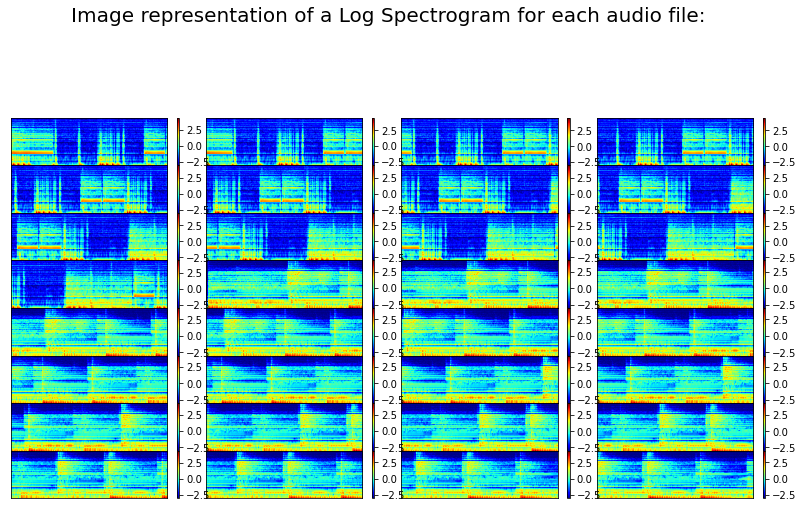

torch.Size([32, 1, 80, 563])
Temps de calcul pour la conv : 6.012121836344401e-06min
Temps de calcul pour maxpool : 2.110004425048828e-06min
Temps de calcul pour batchnorm : 2.516508102416992e-05min
Temps de calcul pour la conv : 7.95125961303711e-06min
Temps de calcul pour la conv : 6.874402364095052e-07min
torch.Size([32, 10, 39, 187])
Temps de calcul pour la conv : 2.777576446533203e-06min
Temps de calcul pour maxpool : 2.272923787434896e-06min
Temps de calcul pour batchnorm : 3.3895174662272136e-06min
Temps de calcul pour la conv : 1.933177312215169e-05min
Temps de calcul pour la conv : 6.755193074544271e-07min
torch.Size([32, 20, 18, 61])
torch.Size([32, 21960])


In [27]:
with torch.no_grad():
    print(test_net.forward(X.cuda()).shape)

In [28]:
test_net.out_dim

21960

In [29]:
del test_net

In [30]:
Main_net.eval()
with torch.no_grad():
    print(Main_net.forward(X.cuda()).shape)
Main_net.train()
print(CNN_arch)

torch.Size([32, 41])
{'input_dim': 25600, 'fs': 32000, 'cnn_N_filt': [80, 10, 20], 'cnn_len_filt_W': [251, 3, 3], 'cnn_len_filt_H': [0, 3, 3], 'cnn_energy_L': 30, 'cnn_energy_stride': 15, 'cnn_max_pool_len_W': [3, 3, 3], 'cnn_max_pool_len_H': [1, 2, 2], 'cnn_use_laynorm_inp': True, 'cnn_use_batchnorm_inp': False, 'cnn_use_laynorm': [False, False, False], 'cnn_use_batchnorm': [True, True, True], 'cnn_act': ['leaky_relu', 'leaky_relu', 'leaky_relu'], 'cnn_drop': [0.0, 0.0, 0.0]}


## Learning rate finder:

The thread where the idea originated from is accessible [here.](https://discuss.pytorch.org/t/get-the-best-learning-rate-automatically/58269/7) <br>
The thread where the code originated from is accessible [here.](https://forums.fast.ai/t/automated-learning-rate-suggester/44199)

In [31]:
## import the tools from fastai:
from fastai.basics import *

In [32]:
valid_dataset.is_fastai = True

databunch = DataBunch.create(train_dataset, valid_dataset, bs=32, device = torch.device('cuda'))
learn = Learner(databunch, Main_net, loss_func = cost, metrics = accuracy)

In [33]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = False) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
0.022908676527677745


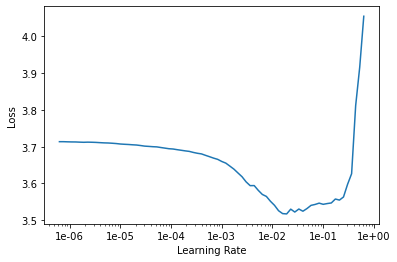

In [34]:
lr = find_appropriate_lr(learn)
learn.recorder.plot()
print(lr)

In [35]:
"learn.fit(1)"

'learn.fit(1)'

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


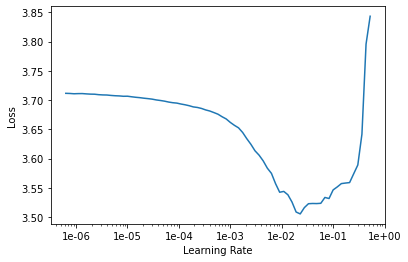

In [37]:
## Fast ai modules finish here, so we switch back to old dataset:
learn.lr_find()
learn.recorder.plot()
valid_dataset.is_fastai = False

In [36]:
#lr=0.005

## Optim and Net learning:

For a **theoretical perspective** of optimization functions, see <cite>Goodfellow, Ian. Deep Learning. Cambridge, Massachusetts, The MIT Press, Publication Date</cite> chapter 8, paragraph 5.
<br>
For the **pytorch documentation** of these functions see [here.](https://pytorch.org/docs/stable/optim.html)<br>
For a brief explication on each optimizer see [here](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/#:~:text=While%20momentum%20accelerates%20our%20search,of%20both%20Momentum%20and%20RMSProp.). **RMSProp vs Adam**, both have adaptive Learning Rates. 
![Optimization evolution figure](Images/optims.jpg)<br>
<center><b>Thanks Paul for the Image!</b></center>

In [38]:

## Uses by default RMSprop optimization
# Maybe use adam Like Paul ??? Faire des tests (chapitre 8 paragraphe 5) + SGD

# Added momentum:
momentum = 0.9 if use_mixup else 0
## Try Adam
optimizer_CNN  = optim.RMSprop(CNN_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 
optimizer_DNN1 = optim.RMSprop(DNN1_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 
optimizer_DNN2 = optim.RMSprop(DNN2_net.parameters(), lr=lr,alpha=0.95, eps=1e-8, momentum=momentum) 


In [39]:
# Dummy class Created to regroup all optimizers into a single object:

class Optimizers(object):

    def __init__(self, optimizer_CNN, optimizer_DNN1, optimizer_DNN2):
        self.optimizer_CNN  = optimizer_CNN
        self.optimizer_DNN1 = optimizer_DNN1
        self.optimizer_DNN2 = optimizer_DNN2
    
    def step(self):
        self.optimizer_CNN.step()
        self.optimizer_DNN1.step()
        self.optimizer_DNN2.step()
        
    def zero_grad(self):
        self.optimizer_CNN.zero_grad() 
        self.optimizer_DNN1.zero_grad()
        self.optimizer_DNN2.zero_grad()

In [40]:
optimizers = Optimizers(optimizer_CNN, optimizer_DNN1, optimizer_DNN2)


### Defining schedulers for each optimizers:

The documentation of the scheduler used can be accessed [here](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.ReduceLROnPlateau).

In [41]:

## Initializing all schedulers for optims:
scheduler_CNN  = optim.lr_scheduler.ReduceLROnPlateau(optimizer_CNN, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
scheduler_DNN1 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_DNN1, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)
scheduler_DNN2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_DNN2, mode='min', factor=scheduler_factor, patience=scheduler_patience, verbose=False, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-08)

#nbre of training batches per epoch:
#nbre_batch_epoch = snt_tr / batch_size
#step_in_epoch    = 8

#base_lr = max_lr/4 for triangular
#optim.lr_scheduler.CyclicLR(optimizer_CNN, base_lr=0.0001, max_lr=0.001, step_size_up=nbre_batch_epoch*step_in_epoch, step_size_down=None, mode='triangular2', gamma=1.0, scale_fn=None, scale_mode='cycle', cycle_momentum=True, base_momentum=0.8, max_momentum=0.9, last_epoch=-1)

In [42]:
# Dummy class Created to regroup all schedulers into a single object:

class Schedulers(object):
    
    def __init__(self, scheduler_CNN, scheduler_DNN1, scheduler_DNN2):
        self.scheduler_CNN  = scheduler_CNN
        self.scheduler_DNN1 = scheduler_DNN1
        self.scheduler_DNN2 = scheduler_DNN2
        
    def step(self, metric):
        self.scheduler_CNN.step(metric)
        self.scheduler_DNN1.step(metric)
        self.scheduler_DNN2.step(metric)

In [43]:
schedulers = Schedulers(scheduler_CNN, scheduler_DNN1, scheduler_DNN2)

### Monitoring the gradient:

This code is taken from a pytorch discussion that you can find [here](https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063). 

**Remarks:**

   * We added `and (p.grad is not None)` to each function because some parameters are initialized and named but not learned or used. Therefore their grad is None and has no attribute abs()!
   * It affects parameters like `bn.1.bias`who are initialized but not used in forward and disabled because the config file their are set as so in the config file. We chose to use layernorm instead.

#### Simple function, plots the values:

In [44]:
def plot_grad_flow_simple(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and (p.grad is not None):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

#### More complex functions in order to plot hist:

In [45]:
from matplotlib.lines import Line2D

## Gradient histogram rep, Calot's suggestion:
def plot_grad_flow(named_parameters, plot_both = False):
    '''Plots the gradients flowing through different layers in the net during training.
    Can be used for checking for possible gradient vanishing / exploding problems.
    
    Usage: Plug this function in Trainer class after loss.backwards() as 
    "plot_grad_flow(self.model.named_parameters())" to visualize the gradient flow'''
    ave_grads = []
    max_grads= []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n) and (p.grad is not None):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
            max_grads.append(p.grad.abs().max())
    plt.bar(np.arange(len(max_grads)), max_grads, alpha=0.1, lw=1, color="c")
    plt.bar(np.arange(len(max_grads)), ave_grads, alpha=0.1, lw=1, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, lw=2, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(left=0, right=len(ave_grads))
    plt.ylim(bottom = -0.001, top=0.02) # zoom in on the lower gradient regions
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    
    ## Plotting also lines like in plot_grad_flow_simple:
    if(plot_both):
        plt.plot(ave_grads, alpha=0.3, color="b")
        plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
        plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
        plt.xlim(xmin=0, xmax=len(ave_grads))
    
    plt.grid(True)
    plt.legend([Line2D([0], [0], color="c", lw=4),
                Line2D([0], [0], color="b", lw=4),
                Line2D([0], [0], color="k", lw=4)], ['max-gradient', 'mean-gradient', 'zero-gradient'])
    
    


### Confusion Matrix API:

In [46]:
import seaborn as sn
import pandas as pd


## Loaded the list of indexes I already created:
dictOfLabels = np.load("data_lists/labelsToNumberDict.npy").item()

## List of labels
index = [0 for i in range (0, len(dictOfLabels))]

## Putting the label in the right order
for label, i in  dictOfLabels.items():
    index[i] = label

    
def confusion_matrix(mat, qty, pred=None, labels=None, index = index, write_results = False, name = "Test", cuda = True): 
    size = len(index)
    
    if(write_results):
        
        ## Dividing by total number:
        for k in range(size):
            if(qty[k]!= 0):
                mat[k] *= 1/qty[k]
                
        ## Converting mat into data frame in order to use seaborn:
        dataframe = pd.DataFrame(mat, index=index)
        sn.set(font_scale=1)

        # Creates the heatmap:
        fig=plt.figure(figsize=(15, 12), dpi= 400, facecolor='w', edgecolor='k')
        svm = sn.heatmap(dataframe, annot=False)

        # Saves the figure than plots it:
        figure = svm.get_figure()
        figure.savefig('Images/Confusion_Matrices/Conf_Mat_' + name +'.png', dpi=400)
        
        del figure
        #plt.show()
        
    else:
    
        if(pred is None or labels is None):
            print("Error, inputs can't be None if not in write results mode.")
            return -1

        if(mat is None):
            #print("Initialize confusion matrix")
            mat = np.zeros([size,size])
        
        if(qty is None):
            qty = [0]*size
        
        if cuda and (not pred.is_cuda or not labels.is_cuda):
            pred   = pred.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        
        
        for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
         # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
            mat[labels[k].item(),pred[k].item()] +=1
            qty[labels[k].item()]                +=1
            
        
            
    return mat, qty

### Mixup Augmentation:

Credit to Lionel, see original file [here](https://gitlab.tech.orange/lionel.delphinpoulat/dcase2018_task5/-/blob/master/datagenerator.py).<br>
Also, this repos helped, see [here](https://github.com/hysts/pytorch_mixup/blob/master/utils.py).<br>
To convert into one_hot encoded we use `tensor.scatter_(dim, index, src)`. Its documentation is available [here](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.scatter_).<br>

    Brief description :
> Writes all values from the tensor `src` into `self` at the indices specified in the `index` tensor. For each value in `src`, its output index is specified by its index in `src` for `dimension != dim` and by the corresponding value in `index` for `dimension = dim`.

In [47]:
def onehot(label, n_classes):
    return torch.zeros(label.size(0), n_classes).scatter_(
        1, label.view(-1, 1), 1)

def mixup(data, targets, beta_coef, n_classes, sameClasses = False, debug = False):
    if(data.size(0) != targets.size(0)):
        print("The amount of data and labels are not the same !")
        return -1
    
    if(sameClasses):
        indices_by_labels = {}
        
        for i, el in enumerate(targets):
            ## Gets the value in the tensor:
            el = el.item()
            
            if indices_by_labels.get(el) is None:
                indices_by_labels[el] = [i]
            else:
                l = indices_by_labels[el]
                l.append(i)
                indices_by_labels[el] = l
                        
        indices = torch.zeros(targets.size(0), dtype = torch.long)
        
        for key in indices_by_labels.keys():
            
            initial_ids = np.array(indices_by_labels[key])
            
            perm        = np.random.permutation(initial_ids.size)
            
            new_ids     = initial_ids[perm]
            
            indices[torch.from_numpy(initial_ids)] = torch.from_numpy(new_ids)
            
        #print(targets == targets[indices])
        
    else:
        # Creates a random permutation for the data:
        indices = torch.randperm(data.size(0))

        
    # Creates mixed up data:
    data_mix    = data[indices]
    targets_mix = targets[indices]

    # Converts labels into one_hot encoded labels:
    targets     = onehot(targets, n_classes)    
    targets_mix = onehot(targets_mix, n_classes)
    
    # draws the mixup coefficient
    mixup_var = torch.FloatTensor(np.random.beta(beta_coef, beta_coef, data.size(0)))
    
    # Computes the percentage of data that are affected by the mixup:
    mixup_percentage = np.array([i for i in range (data.size(0))]) != np.array([el.item() for el in indices])
    
    for i, el in enumerate(mixup_var):
        mixup_percentage[i] = (mixup_percentage[i] and (el < 0.9999))

    mixup_percentage = sum(mixup_percentage)/data.size(0)
    
    if debug:
        print("mix_var shape %s" % str(mixup_var.shape))
        print("X shape %s" % str(data.shape))
        print("labels %s" % str(targets))
        print("mixup vars :", mixup_var)
        print("Indices :", indices)
        
    # applies mixup to both input data and one-hot encoded labels
    X = torch.rand(data.shape, dtype = torch.float)
    
    for i in range (data.size(0)):
        X[i] = data[i] * mixup_var[i] + data_mix[i] * (1. - mixup_var[i])
        
    y = torch.rand((data.size(0), n_classes), dtype = torch.float)
    
    for i in range (targets.size(0)):    
        y[i] = (targets[i] * mixup_var[i] + targets_mix[i] * (1. - mixup_var[i]))
    
    if debug:
        print("mix label shape %s" % str(y.shape))
        print("%s" % str(y[0]))
    
    return X, y, mixup_percentage


#### Beta density plot:

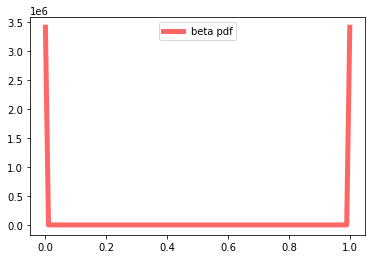

In [48]:
from scipy.stats import beta
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)

a, b = 0.4, 0.4
mean, var, skew, kurt = beta.stats(a, b, moments='mvsk')

x = np.linspace(beta.ppf(0.00001, a, b),
                beta.ppf(0.99999, a, b), 100)

ax.plot(x, beta.pdf(x, a, b),
       'r-', lw=5, alpha=0.6, label='beta pdf')

plt.legend()
plt.show()

#### Redefining cost function for one hot encoded labels:

In [49]:
def NLLL_onehot(input, target, reduction= "mean"):

    loss = -torch.sum(input[:,:target.size(1)] * target.float())
    
    if "mean" in reduction:
        return loss / input.size(0)
    else:
        return loss


class NLLL_OneHot(object):
    def __init__(self, reduction= "mean"):
        self.reduction = reduction

    def __call__(self, input, target):
        return NLLL_onehot(input, target, self.reduction)

In [50]:
## Initializing new cost function:
cost_onehot = NLLL_OneHot()

### Early Stopping:

For a **theoretical perspective**, please refer to <cite>Goodfellow, Ian. Deep Learning. Cambridge, Massachusetts, The MIT Press, Publication Date</cite> chapter 7, paragraph 8, page 240, algorithm $7.1$.<br>


In [51]:
"""
@Batch_dev is the number of test tensors that are stored at once
"""
def accuracy(net, test_loader, criterion, 
             ## SincNet Params
             Batch_dev, wlen, wshift,
             ## Confusion_Matrix param:
             matrix_name, compute_matrix = False,
             cuda=True):
    
    ## Modifs pour SincNet
    net.eval()
    

    loss_sum=0
    err_sum=0
    err_sum_snt=0
    ## End
    
    with torch.no_grad():
        
        # Initializes confusion matrix and quantity to None:
        mat = None
        qty = None
        
        ## Initialisation of storing units for testing:
        stored_outs   = 0
        stored_labels = 0
        stored_idx    = 0
            
        
        ## For SincNet, information in testloader is raw and can be of various lengths!
        for data in test_loader:
            ## Stores data from test_loader:
            audios, labels, file_ids = data
            
            ## Switches to cuda:
            if cuda:
                audios = audios.type(torch.cuda.FloatTensor)
                labels = labels.type(torch.cuda.LongTensor)
            
            
            ## <!> Splits the data by file: time_complexity = O(batch_size) and space_complexity = O(Number_Of_Files)
            section  = []
            ids_list = []
            current_idx = file_ids[0].item()
            ids_list.append(current_idx)
            for i, el in enumerate(file_ids):
                current_el = el.item()
                if current_el != current_idx:
                    current_idx = current_el
                    ids_list.append(current_idx)
                    section.append(i - sum(section))

            ## Last section is added:    
            section.append(audios.size(0) - sum(section))
            #print(section)
            #print(ids_list)

            ## Algorithm that splits the tensors by file:
            X_split = torch.split(audios, section)
            y_split = torch.split(labels, section)

            assert(len(X_split) == len(y_split))
            ## <!> EndSplit <!>

            
            ## Processes file by file the data:
            for i in range(len(X_split)):# nbre_fichier_par_batch= len(X_split)
                ## Stores the current id:
                current_idx    = ids_list[i]
                current_data   = X_split[i] if len(X_split) >= 1 else X_split
                current_labels = y_split[i] if len(y_split) >= 1 else y_split

                if type(stored_outs) is not torch.Tensor:
                    stored_idx    = current_idx
                    stored_outs   = net(current_data)
                    stored_labels = current_labels

                    ## Updates the number of signals
                    #nbr_snt      += 1
                else:

                    if(stored_idx == current_idx):
                        stored_outs   = torch.cat([stored_outs, net(current_data)], dim=0)
                        stored_labels = torch.cat([stored_labels, current_labels], dim=0)

                    else:

                        #pout = stored_outs

                        ## Predicts for every chunk of audio the label and counts how many time it got it correctly
                        pred = torch.max(stored_outs,dim=1)[1]
                        loss = criterion(stored_outs, stored_labels.long())
                        err  = torch.mean((pred!=stored_labels.long()).float())

                        ## Updates the confusion matrix:
                        if(compute_matrix):
                            mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

                        ## Updates the error that I use here:
                        loss_sum=loss_sum+loss.detach()
                        err_sum=err_sum+err.detach()

                        ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
                        [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
                        err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()

                        ## Stores new data:
                        stored_outs   = net(current_data)
                        stored_labels = y_split[i] if len(y_split) >= 1 else y_split
                        stored_idx    = current_idx
        
        ## Last File is not processed by the algorithm above...
        if(stored_outs.size(0) != 0):
            ## Predicts for every chunk of audio the label and counts how many time it got it correctly
            pred = torch.max(stored_outs,dim=1)[1]
            loss = criterion(stored_outs, stored_labels.long())
            err  = torch.mean((pred!=stored_labels.long()).float())

            ## Updates the confusion matrix:
            if(compute_matrix):
                mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

            ## Updates the error that I use here:
            loss_sum=loss_sum+loss.detach()
            err_sum=err_sum+err.detach()

            ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
            [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
            err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()
        
        ## mean Error of best class:
        err_tot_dev_snt=err_sum_snt/snt_te
        
        ## mean Loss:
        loss_tot_dev=loss_sum/snt_te
        
        ## mean Error on each window:
        err_tot_dev=err_sum/snt_te

        ## Plots and saves the confusion matrix:
        if(compute_matrix):
            mat = confusion_matrix(mat, qty, write_results = True, name = matrix_name, cuda = True)
            
            
    net.train()

    return (err_tot_dev_snt, loss_tot_dev, err_tot_dev)

def train(net, optimizer, train_loader, valid_loader, criterion, criterion_onehot,
          ## SincNet variables:
          wlen,
          wshift,
          n_classes,
          ## File variables:
          output_folder,
          fname,
          Models_file_extension,
          ## Hyper param:
          n_epoch = 5,
          patience = 4,
          Batch_dev = 32,#Number of batches for testing set
          train_acc_period = 100,
          test_acc_period = 5,
          ## For mixup:
          beta_coef = 0.5,
          use_mixup = False,
          same_classes = False,
          ## If a Net was loaded:
          starting_epoch = 0,
          ## If user wishes to plot grad:
          plotGrad = False,
          ## If user wishes to use a scheduler:
          use_scheduler = False,
          scheduler = None,
          ## If user wishes to save and compute confusion matrix:
          compute_matrix = False,
          ## Indicates if the network that is trained is SincNet
          is_SincNet = False,
          ## Is Cuda activated?
          cuda=True):
    
    net.train()

    ## Initialization:
    min_loss = float("inf")
    
    ## best_epoch_number is a var that stores the number of epoch required for best performance:
    best_epoch_number = 0
    
    ## p is a counter for how many accuracy checks we made without any improvement on validation loss:
    p=0
    
    ## Declaring to the user that training has begun
    print("Trainining begun with a patience of {} accuracy periods".format(patience), end="")
    if(use_mixup):
        string = ""
        if(same_classes):
            string = "Same Class "
        print(" and using {1}mixup with a Beta({0}, {0}) distribution.".format(beta_coef, string))
    else:
        print(".")
    if use_scheduler:
        print("Training is optimized with a scheduler.")
    print("Total number of classes is equal to : {}".format(n_classes))
    
    ## Continues training beyond n_epoch if algorithm did not converge:
    while(p < patience):
        
        for epoch in tqdm.tqdm(range(starting_epoch + 1, n_epoch + starting_epoch + 1)):  # loop over the dataset multiple times

            ## Stops the training if we exceeded its patience!
            if(p >= patience):
                break


            running_loss = 0.0
            running_acc = 0.0
            running_mixup_percentage = 0.0

            for i, data in enumerate(train_loader, 0):

                # Getting Mixed up data if required by user:
                if(use_mixup):
                    inputs, labels, mixup_states     = data
                    mixup_percentage                 = mixup_states.sum().item() / inputs.size(0)
                    running_mixup_percentage         = 0.33*mixup_percentage + 0.66*running_mixup_percentage
                else:
                    # gets the regular inputs
                    inputs, labels = data
                    
                    

                if cuda:
                    inputs = inputs.type(torch.cuda.FloatTensor)
                    labels = labels.type(torch.cuda.LongTensor)

                # print(inputs.shape)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward + backward + optimize
                outputs = net(inputs)

                ## Loss evaluation:
                    # We use custom made function if there is mixup envolved
                    # Else, we use regular criterion from pytorch
                if(use_mixup):
                    loss = criterion_onehot(outputs, labels.long())
                else:
                    loss = criterion(outputs, labels.long())
                    
                    
                loss.backward()

                ## Plotting the grad for frequencies and second layer 1Dconv:
                if(plotGrad):
                    plot_grad_flow(net.named_parameters())   
                    #plot_grad_flow_simple(net.named_parameters())

                optimizer.step()
                    
                ## If we used mixup, we need to convert back labels to og format.
                if(use_mixup):
                    labels = torch.max(labels, dim = 1)[1]

                running_loss = 0.33*loss.detach() + 0.66*running_loss
                predicted = torch.max(outputs.data, dim = 1)[1]

                ## @correct is the percentage of correct answers by the Net.
                correct = (predicted == labels).sum().item()/labels.size(0)
                running_acc = 0.33*correct + 0.66*running_acc

                # prints statistics during epoch!
                if i % train_acc_period == train_acc_period-1:
                    print("Training set : ")
                    print('[%d, %5d] running loss: %.3f' %(epoch, i + 1, running_loss))
                    print('[%d, %5d] running acc: %.3f' %(epoch, i + 1, running_acc))
                    
                    if use_mixup:
                        print('[%d, %5d] running mixup percentage: %.3f' %(epoch, i + 1, running_mixup_percentage))



            ## Validation loop part:
            if epoch % test_acc_period == 0:
                best_class_error, cur_loss, window_error = accuracy(net, valid_loader, criterion, 
                                                                    Batch_dev, wlen, wshift,
                                                                    matrix_name = fname, compute_matrix = compute_matrix,
                                                                    cuda=cuda)
                
                
                
                ## If user wishes to use a scheduler:
                if(use_scheduler):
                    scheduler.step(cur_loss)


                ## Writing the results in the specified file:
                with open(output_folder+"/" + fname + ".res", "a") as res_file:
                    res_file.write("epoch %i, running_loss_tr=%f running_acc_tr=%f best_class_acc_te=%f loss_te=%f window_acc_te=%f \n" % 
                                                                                                 (epoch,
                                                                                                 running_loss,
                                                                                                 running_acc,
                                                                                                 1-best_class_error,
                                                                                                 cur_loss,
                                                                                                 1-window_error))   

                print("\n")
                print("Validation set : ")
                print('[%d] test loss: %.3f'       %(epoch, cur_loss))
                print('[%d] window acc: %.3f'      %(epoch, 1-window_error))
                print('[%d] best class acc: %.3f'  %(epoch, 1-best_class_error))


                if(cur_loss < min_loss):
                    ## Saves the new loss:
                    min_loss = cur_loss

                    ## Saves the parameters if they are better:
                    # SincNet saving method:
                    if is_SincNet:
                        torch.save(net.CNN_net.state_dict(), output_folder + '/' + fname + "_CNN" + Models_file_extension)
                        torch.save(net.DNN1_net.state_dict(), output_folder+ '/' + fname + "_DNN1" + Models_file_extension)
                        torch.save(net.DNN2_net.state_dict(), output_folder+ '/' + fname + "_DNN2" + Models_file_extension)
                    
                    # Regular save:
                    torch.save(net.state_dict(), output_folder+ '/' + fname + "_Main_net" + Models_file_extension)

                    ## Resets the patience, we found a better net.
                    p = 0

                    ## Stores the best number of epoch:
                    best_epoch_number = epoch

                else:
                    p +=1
        
        ## Inside While scope:
        starting_epoch += n_epoch#Here we go again...


      
    print('Finished Training, the best number of epoch was {}.'.format(best_epoch_number))
    
    # If user wants to plot grad: 
    if(plotGrad):
        ## Saves figure:
        plt.savefig("Images/" + fname + "_GradFlow.png", format = 'png')
        
        ## Then shows the figure:
        plt.show()
        


#### Loading previously trained model if needed:

In [52]:
def LoadPrevModel(model_file_path, Models_file_extension, Load, evalMode = False, inSameFile = True, at_epoch = N_epochs):
    if(Load == False):
        return 0
    
    
    ## Setting the parameters of the previously defined networks 
    global Main_net, CNN_net, DNN1_net, DNN2_net
    
    
    if(inSameFile):
        ## Loading the pretrained setup file
        pretrainedSetup = torch.load(model_file_path + Models_file_extension)
        #print(pretrainedSetup['CNN_model_par'])
        
        ## Loading net parameters one by one:
        CNN_net.load_state_dict(pretrainedSetup['CNN_model_par'])
        if(evalMode):CNN_net.eval()

        DNN1_net.load_state_dict(pretrainedSetup['DNN1_model_par'])
        if(evalMode):DNN1_net.eval()

        DNN2_net.load_state_dict(pretrainedSetup['DNN2_model_par'])
        if(evalMode):DNN2_net.eval()
                    
    else:
        ## Loading all the pretrained setup file
        
        pretrainedSetup_CNN  = torch.load(model_file_path + "_CNN" + Models_file_extension)
        pretrainedSetup_DNN1 = torch.load(model_file_path + "_DNN1" + Models_file_extension)
        pretrainedSetup_DNN2 = torch.load(model_file_path + "_DNN2" + Models_file_extension)
        
        ## Loading net parameters one by one:
        CNN_net.load_state_dict(pretrainedSetup_CNN)
        if(evalMode):CNN_net.eval()

        DNN1_net.load_state_dict(pretrainedSetup_DNN1)
        if(evalMode):DNN1_net.eval()

        DNN2_net.load_state_dict(pretrainedSetup_DNN2)
        if(evalMode):DNN2_net.eval()
    
    
    
    ## Putting all the nets into Main_net:
    Main_net = Main_net = MainNet(CNN_net, DNN1_net, DNN2_net)
    if(evalMode):Main_net.eval()

    
    #print(CNN_net.state_dict()['conv.0.low_hz_'][0])
    
    print("Models from " + model_file_path + " were loaded successfully!")
    
    return at_epoch + 1

In [53]:
## Parameters that needs to change each execution:
Training_model_file   = output_folder.split("/")[-2] if output_folder.split("/")[-1]=="" else output_folder.split("/")[-1]
Training_model_file  += "_Notebook"
Models_file_extension = ".pkl" if pt_file == 'none' else pt_file.split(".")[1]
previous_model_path   = output_folder+ '/' + Training_model_file if pt_file == 'none' else pt_file.split(".")[0]
Load_previous_model   = False if pt_file == 'none' else True
at_epoch              = 0
inTheSameFile         = False
plotGrad              = False
n_classes             = class_lay[-1]#41 for SincNet
same_classes          = same_classes
compute_matrix        = False
is_SincNet            = True
#use_scheduler         = True


## are in cfg:
#beta_coef=0.4
#use_mixup
#N_eval_epoch = 1
#same_classes = True


## Loading previously trained model if needed:
previous_epoch = LoadPrevModel(previous_model_path, 
                               Models_file_extension, 
                               Load= Load_previous_model, 
                               inSameFile = inTheSameFile,
                               at_epoch = at_epoch,
                               evalMode = True)


## Training parameters available in the SincNet_TIMIT.cfg file section [optimization]:
# batch_size
# N_epochs     = 1500
# N_batches    = 800
# N_eval_epoch = 8

## Overwriting N_epochs just bcz flemme:
#N_epochs = 58



#### Training occurs below:

In [ ]:
train(Main_net, optimizers, train_loader, valid_loader, cost, cost_onehot,
          ## SincNet variables:
          wlen,
          wshift,
          n_classes,
          ## File variables:
          output_folder,
          Training_model_file,
          Models_file_extension,
          ## Hyper param:
          n_epoch = N_epochs,
          patience = patience,
          Batch_dev = Batch_dev,#Number of batches for testing set
          train_acc_period = train_acc_period,
          test_acc_period = N_eval_epoch,
          ## For Mixup
          beta_coef = beta_coef,
          use_mixup = use_mixup,
          same_classes = same_classes,
          ## Loaded model params:
          starting_epoch = previous_epoch,
          ## Tracking gradient
          plotGrad = plotGrad,
          ## If user wishes to use scheduler:
          use_scheduler = use_scheduler,
          scheduler = schedulers,
          ## If user wishes to save and compute confusion matrix:
          compute_matrix = compute_matrix,
          ## Indicates if the network that is trained is SincNet
          is_SincNet = is_SincNet,
          cuda=True)


  0%|          | 0/100 [00:00<?, ?it/s]

Trainining begun with a patience of 7 accuracy periods.
Training is optimized with a scheduler.
Total number of classes is equal to : 41
Training set : 
[1,   100] running loss: 2.701
[1,   100] running acc: 0.216
Training set : 
[1,   200] running loss: 2.521
[1,   200] running acc: 0.262


  1%|          | 1/100 [00:22<36:43, 22.26s/it]

Training set : 
[2,   100] running loss: 2.207
[2,   100] running acc: 0.378
Training set : 
[2,   200] running loss: 2.159
[2,   200] running acc: 0.364


  2%|▏         | 2/100 [00:44<36:21, 22.26s/it]

Training set : 
[3,   100] running loss: 2.169
[3,   100] running acc: 0.393
Training set : 
[3,   200] running loss: 2.088
[3,   200] running acc: 0.384


  3%|▎         | 3/100 [01:06<36:02, 22.29s/it]

Training set : 
[4,   100] running loss: 2.150
[4,   100] running acc: 0.329
Training set : 
[4,   200] running loss: 1.737
[4,   200] running acc: 0.523


  4%|▍         | 4/100 [01:29<35:38, 22.28s/it]

Training set : 
[5,   100] running loss: 2.018
[5,   100] running acc: 0.419
Training set : 
[5,   200] running loss: 1.874
[5,   200] running acc: 0.477


  5%|▌         | 5/100 [02:53<1:04:36, 40.81s/it]



Validation set : 
[5] test loss: 1.923
[5] window acc: 0.466
[5] best class acc: 0.519
Training set : 
[6,   100] running loss: 1.845
[6,   100] running acc: 0.462
Training set : 
[6,   200] running loss: 1.708
[6,   200] running acc: 0.498


  6%|▌         | 6/100 [03:15<55:20, 35.32s/it]  

Training set : 
[7,   100] running loss: 1.852
[7,   100] running acc: 0.451
Training set : 
[7,   200] running loss: 1.760
[7,   200] running acc: 0.501


  7%|▋         | 7/100 [03:38<48:50, 31.51s/it]

Training set : 
[8,   100] running loss: 1.579
[8,   100] running acc: 0.542
Training set : 
[8,   200] running loss: 1.831
[8,   200] running acc: 0.438


  8%|▊         | 8/100 [04:00<44:12, 28.84s/it]

Training set : 
[9,   100] running loss: 1.704
[9,   100] running acc: 0.486
Training set : 
[9,   200] running loss: 1.604
[9,   200] running acc: 0.557


  9%|▉         | 9/100 [04:23<40:48, 26.90s/it]

Training set : 
[10,   100] running loss: 1.607
[10,   100] running acc: 0.546
Training set : 
[10,   200] running loss: 1.649
[10,   200] running acc: 0.507


Validation set : 
[10] test loss: 1.707
[10] window acc: 0.524
[10] best class acc: 0.588


 10%|█         | 10/100 [05:49<1:07:02, 44.70s/it]

Training set : 
[11,   100] running loss: 1.573
[11,   100] running acc: 0.513
Training set : 
[11,   200] running loss: 1.842
[11,   200] running acc: 0.426


 11%|█         | 11/100 [06:12<56:33, 38.13s/it]  

Training set : 
[12,   100] running loss: 1.469
[12,   100] running acc: 0.590
Training set : 
[12,   200] running loss: 1.495
[12,   200] running acc: 0.579


 12%|█▏        | 12/100 [06:35<49:13, 33.56s/it]

Training set : 
[13,   100] running loss: 1.814
[13,   100] running acc: 0.475
Training set : 
[13,   200] running loss: 1.766
[13,   200] running acc: 0.482


 13%|█▎        | 13/100 [06:58<44:01, 30.36s/it]

Training set : 
[14,   100] running loss: 1.508
[14,   100] running acc: 0.550
Training set : 
[14,   200] running loss: 1.724
[14,   200] running acc: 0.480


 14%|█▍        | 14/100 [07:21<40:18, 28.12s/it]

Training set : 
[15,   100] running loss: 1.487
[15,   100] running acc: 0.564
Training set : 
[15,   200] running loss: 1.406
[15,   200] running acc: 0.626


Validation set : 
[15] test loss: 1.675
[15] window acc: 0.546
[15] best class acc: 0.608


 15%|█▌        | 15/100 [08:47<1:04:32, 45.56s/it]

Training set : 
[16,   100] running loss: 1.648
[16,   100] running acc: 0.472
Training set : 
[16,   200] running loss: 1.696
[16,   200] running acc: 0.501


 16%|█▌        | 16/100 [09:10<54:17, 38.78s/it]  

Training set : 
[17,   100] running loss: 1.477
[17,   100] running acc: 0.563
Training set : 
[17,   200] running loss: 1.648
[17,   200] running acc: 0.450


 17%|█▋        | 17/100 [09:33<47:01, 34.00s/it]

Training set : 
[18,   100] running loss: 1.488
[18,   100] running acc: 0.553
Training set : 
[18,   200] running loss: 1.352
[18,   200] running acc: 0.534


 18%|█▊        | 18/100 [09:55<41:55, 30.67s/it]

Training set : 
[19,   100] running loss: 1.574
[19,   100] running acc: 0.555
Training set : 
[19,   200] running loss: 1.546
[19,   200] running acc: 0.524


 19%|█▉        | 19/100 [10:18<38:16, 28.35s/it]

Training set : 
[20,   100] running loss: 1.478
[20,   100] running acc: 0.527
Training set : 
[20,   200] running loss: 1.823
[20,   200] running acc: 0.472


Validation set : 
[20] test loss: 1.647
[20] window acc: 0.549
[20] best class acc: 0.613


 20%|██        | 20/100 [11:44<1:00:52, 45.66s/it]

Training set : 
[21,   100] running loss: 1.642
[21,   100] running acc: 0.555
Training set : 
[21,   200] running loss: 1.681
[21,   200] running acc: 0.506


 21%|██        | 21/100 [12:05<50:17, 38.20s/it]  

Training set : 
[22,   100] running loss: 1.644
[22,   100] running acc: 0.497
Training set : 
[22,   200] running loss: 1.484
[22,   200] running acc: 0.555


 22%|██▏       | 22/100 [12:27<43:05, 33.15s/it]

Training set : 
[23,   100] running loss: 1.081
[23,   100] running acc: 0.662
Training set : 
[23,   200] running loss: 1.199
[23,   200] running acc: 0.666


 23%|██▎       | 23/100 [12:49<38:21, 29.89s/it]

Training set : 
[24,   100] running loss: 1.397
[24,   100] running acc: 0.555
Training set : 
[24,   200] running loss: 1.259
[24,   200] running acc: 0.619


 24%|██▍       | 24/100 [13:11<34:59, 27.63s/it]

Training set : 
[25,   100] running loss: 1.239
[25,   100] running acc: 0.615
Training set : 
[25,   200] running loss: 1.247
[25,   200] running acc: 0.613


 25%|██▌       | 25/100 [14:37<56:22, 45.10s/it]



Validation set : 
[25] test loss: 1.674
[25] window acc: 0.565
[25] best class acc: 0.630
Training set : 
[26,   100] running loss: 1.519
[26,   100] running acc: 0.542
Training set : 
[26,   200] running loss: 1.334
[26,   200] running acc: 0.565


 26%|██▌       | 26/100 [14:59<47:09, 38.24s/it]

Training set : 
[27,   100] running loss: 1.358
[27,   100] running acc: 0.560
Training set : 
[27,   200] running loss: 1.203
[27,   200] running acc: 0.598


 27%|██▋       | 27/100 [15:22<40:46, 33.51s/it]

Training set : 
[28,   100] running loss: 1.166
[28,   100] running acc: 0.675
Training set : 
[28,   200] running loss: 1.310
[28,   200] running acc: 0.619


 28%|██▊       | 28/100 [15:44<36:13, 30.19s/it]

Training set : 
[29,   100] running loss: 1.469
[29,   100] running acc: 0.559
Training set : 
[29,   200] running loss: 1.246
[29,   200] running acc: 0.656


 29%|██▉       | 29/100 [16:07<32:58, 27.86s/it]

Training set : 
[30,   100] running loss: 1.244
[30,   100] running acc: 0.596
Training set : 
[30,   200] running loss: 1.572
[30,   200] running acc: 0.548


Validation set : 
[30] test loss: 1.547
[30] window acc: 0.586
[30] best class acc: 0.646


 30%|███       | 30/100 [17:33<52:50, 45.29s/it]

Training set : 
[31,   100] running loss: 1.073
[31,   100] running acc: 0.647
Training set : 
[31,   200] running loss: 1.371
[31,   200] running acc: 0.618


 31%|███       | 31/100 [17:55<44:14, 38.47s/it]

Training set : 
[32,   100] running loss: 1.113
[32,   100] running acc: 0.707
Training set : 
[32,   200] running loss: 1.296
[32,   200] running acc: 0.599


 32%|███▏      | 32/100 [18:18<38:11, 33.70s/it]

Training set : 
[33,   100] running loss: 1.258
[33,   100] running acc: 0.614
Training set : 
[33,   200] running loss: 1.272
[33,   200] running acc: 0.615


 33%|███▎      | 33/100 [18:40<33:53, 30.35s/it]

Training set : 
[34,   100] running loss: 1.175
[34,   100] running acc: 0.613
Training set : 
[34,   200] running loss: 1.508
[34,   200] running acc: 0.575


 34%|███▍      | 34/100 [19:03<30:44, 27.94s/it]

Training set : 
[35,   100] running loss: 1.299
[35,   100] running acc: 0.616
Training set : 
[35,   200] running loss: 1.346
[35,   200] running acc: 0.605


Validation set : 
[35] test loss: 1.459
[35] window acc: 0.606
[35] best class acc: 0.670


 35%|███▌      | 35/100 [20:29<49:10, 45.39s/it]

Training set : 
[36,   100] running loss: 1.240
[36,   100] running acc: 0.639
Training set : 
[36,   200] running loss: 1.248
[36,   200] running acc: 0.641


 36%|███▌      | 36/100 [20:51<41:06, 38.54s/it]

Training set : 
[37,   100] running loss: 1.191
[37,   100] running acc: 0.623
Training set : 
[37,   200] running loss: 1.292
[37,   200] running acc: 0.606


 37%|███▋      | 37/100 [21:14<35:26, 33.76s/it]

Training set : 
[38,   100] running loss: 1.625
[38,   100] running acc: 0.561
Training set : 
[38,   200] running loss: 1.282
[38,   200] running acc: 0.620


 38%|███▊      | 38/100 [21:36<31:22, 30.37s/it]

Training set : 
[39,   100] running loss: 1.179
[39,   100] running acc: 0.660
Training set : 
[39,   200] running loss: 1.203
[39,   200] running acc: 0.607


 39%|███▉      | 39/100 [21:59<28:27, 27.99s/it]

Training set : 
[40,   100] running loss: 1.292
[40,   100] running acc: 0.626
Training set : 
[40,   200] running loss: 1.153
[40,   200] running acc: 0.694


 40%|████      | 40/100 [23:25<45:22, 45.38s/it]



Validation set : 
[40] test loss: 1.512
[40] window acc: 0.613
[40] best class acc: 0.681
Training set : 
[41,   100] running loss: 1.276
[41,   100] running acc: 0.632
Training set : 
[41,   200] running loss: 1.279
[41,   200] running acc: 0.625


 41%|████      | 41/100 [23:47<37:54, 38.55s/it]

Training set : 
[42,   100] running loss: 1.148
[42,   100] running acc: 0.673
Training set : 
[42,   200] running loss: 1.460
[42,   200] running acc: 0.586


 42%|████▏     | 42/100 [24:10<32:37, 33.74s/it]

Training set : 
[43,   100] running loss: 1.204
[43,   100] running acc: 0.622
Training set : 
[43,   200] running loss: 1.256
[43,   200] running acc: 0.624


 43%|████▎     | 43/100 [24:32<28:50, 30.37s/it]

Training set : 
[44,   100] running loss: 1.260
[44,   100] running acc: 0.648
Training set : 
[44,   200] running loss: 1.204
[44,   200] running acc: 0.681


 44%|████▍     | 44/100 [24:55<26:09, 28.02s/it]

Training set : 
[45,   100] running loss: 1.128
[45,   100] running acc: 0.670
Training set : 
[45,   200] running loss: 1.310
[45,   200] running acc: 0.662


 45%|████▌     | 45/100 [26:21<41:33, 45.33s/it]



Validation set : 
[45] test loss: 1.525
[45] window acc: 0.596
[45] best class acc: 0.665
Training set : 
[46,   100] running loss: 1.129
[46,   100] running acc: 0.658
Training set : 
[46,   200] running loss: 1.096
[46,   200] running acc: 0.664


 46%|████▌     | 46/100 [26:43<34:39, 38.51s/it]

Training set : 
[47,   100] running loss: 1.213
[47,   100] running acc: 0.657
Training set : 
[47,   200] running loss: 1.232
[47,   200] running acc: 0.632


 47%|████▋     | 47/100 [27:06<29:49, 33.76s/it]

Training set : 
[48,   100] running loss: 1.203
[48,   100] running acc: 0.648
Training set : 
[48,   200] running loss: 1.249
[48,   200] running acc: 0.622


 48%|████▊     | 48/100 [27:28<26:19, 30.37s/it]

Training set : 
[49,   100] running loss: 1.210
[49,   100] running acc: 0.615
Training set : 
[49,   200] running loss: 1.477
[49,   200] running acc: 0.556


 49%|████▉     | 49/100 [27:51<23:51, 28.06s/it]

Training set : 
[50,   100] running loss: 1.238
[50,   100] running acc: 0.603
Training set : 
[50,   200] running loss: 1.538
[50,   200] running acc: 0.602


 50%|█████     | 50/100 [29:17<37:49, 45.40s/it]

Epoch     9: reducing learning rate of group 0 to 1.0000e-03.


Validation set : 
[50] test loss: 1.637
[50] window acc: 0.587
[50] best class acc: 0.659
Training set : 
[51,   100] running loss: 0.917
[51,   100] running acc: 0.706
Training set : 
[51,   200] running loss: 0.942
[51,   200] running acc: 0.723


 51%|█████     | 51/100 [29:40<31:31, 38.60s/it]

Training set : 
[52,   100] running loss: 1.269
[52,   100] running acc: 0.597
Training set : 
[52,   200] running loss: 0.770
[52,   200] running acc: 0.766


 52%|█████▏    | 52/100 [30:02<27:03, 33.81s/it]

Training set : 
[53,   100] running loss: 1.102
[53,   100] running acc: 0.681
Training set : 
[53,   200] running loss: 0.998
[53,   200] running acc: 0.686


 53%|█████▎    | 53/100 [30:25<23:49, 30.41s/it]

Training set : 
[54,   100] running loss: 1.054
[54,   100] running acc: 0.666
Training set : 
[54,   200] running loss: 1.259
[54,   200] running acc: 0.622


 54%|█████▍    | 54/100 [30:47<21:31, 28.08s/it]

Training set : 
[55,   100] running loss: 0.867
[55,   100] running acc: 0.702
Training set : 
[55,   200] running loss: 1.007
[55,   200] running acc: 0.683


Validation set : 
[55] test loss: 1.340
[55] window acc: 0.654
[55] best class acc: 0.726


 55%|█████▌    | 55/100 [32:14<34:10, 45.58s/it]

Training set : 
[56,   100] running loss: 0.973
[56,   100] running acc: 0.681
Training set : 
[56,   200] running loss: 0.949
[56,   200] running acc: 0.692


 56%|█████▌    | 56/100 [32:35<28:00, 38.20s/it]

Training set : 
[57,   100] running loss: 0.836
[57,   100] running acc: 0.746
Training set : 
[57,   200] running loss: 0.917
[57,   200] running acc: 0.729


 57%|█████▋    | 57/100 [32:56<23:41, 33.05s/it]

Training set : 
[58,   100] running loss: 0.845
[58,   100] running acc: 0.715
Training set : 
[58,   200] running loss: 0.850
[58,   200] running acc: 0.703


 58%|█████▊    | 58/100 [33:17<20:36, 29.45s/it]

Training set : 
[59,   100] running loss: 1.040
[59,   100] running acc: 0.689
Training set : 
[59,   200] running loss: 0.709
[59,   200] running acc: 0.767


 59%|█████▉    | 59/100 [33:38<18:24, 26.93s/it]

Training set : 
[60,   100] running loss: 1.039
[60,   100] running acc: 0.638
Training set : 
[60,   200] running loss: 0.970
[60,   200] running acc: 0.706


 60%|██████    | 60/100 [35:03<29:38, 44.46s/it]



Validation set : 
[60] test loss: 1.341
[60] window acc: 0.656
[60] best class acc: 0.723
Training set : 
[61,   100] running loss: 0.859
[61,   100] running acc: 0.706
Training set : 
[61,   200] running loss: 1.056
[61,   200] running acc: 0.675


 61%|██████    | 61/100 [35:25<24:29, 37.69s/it]

Training set : 
[62,   100] running loss: 1.047
[62,   100] running acc: 0.704
Training set : 
[62,   200] running loss: 0.918
[62,   200] running acc: 0.726


 62%|██████▏   | 62/100 [35:47<20:48, 32.86s/it]

Training set : 
[63,   100] running loss: 0.816
[63,   100] running acc: 0.761
Training set : 
[63,   200] running loss: 1.046
[63,   200] running acc: 0.699


 63%|██████▎   | 63/100 [36:08<18:07, 29.40s/it]

Training set : 
[64,   100] running loss: 0.816
[64,   100] running acc: 0.753
Training set : 
[64,   200] running loss: 0.885
[64,   200] running acc: 0.733


 64%|██████▍   | 64/100 [36:30<16:13, 27.05s/it]

Training set : 
[65,   100] running loss: 0.922
[65,   100] running acc: 0.708
Training set : 
[65,   200] running loss: 0.947
[65,   200] running acc: 0.703


 65%|██████▌   | 65/100 [37:56<26:08, 44.82s/it]



Validation set : 
[65] test loss: 1.346
[65] window acc: 0.659
[65] best class acc: 0.728
Training set : 
[66,   100] running loss: 0.933
[66,   100] running acc: 0.689
Training set : 
[66,   200] running loss: 0.856
[66,   200] running acc: 0.755


 66%|██████▌   | 66/100 [38:20<21:47, 38.45s/it]

Training set : 
[67,   100] running loss: 0.826
[67,   100] running acc: 0.757
Training set : 
[67,   200] running loss: 0.742
[67,   200] running acc: 0.774


 67%|██████▋   | 67/100 [38:43<18:41, 34.00s/it]

Training set : 
[68,   100] running loss: 0.888
[68,   100] running acc: 0.722
Training set : 
[68,   200] running loss: 0.675
[68,   200] running acc: 0.802


 68%|██████▊   | 68/100 [39:06<16:24, 30.78s/it]

Training set : 
[69,   100] running loss: 1.031
[69,   100] running acc: 0.723
Training set : 
[69,   200] running loss: 0.969
[69,   200] running acc: 0.713


 69%|██████▉   | 69/100 [39:29<14:38, 28.33s/it]

Training set : 
[70,   100] running loss: 1.034
[70,   100] running acc: 0.707
Training set : 
[70,   200] running loss: 0.909
[70,   200] running acc: 0.719


 70%|███████   | 70/100 [40:55<22:50, 45.68s/it]

Epoch    13: reducing learning rate of group 0 to 2.0000e-04.


Validation set : 
[70] test loss: 1.355
[70] window acc: 0.659
[70] best class acc: 0.724
Training set : 
[71,   100] running loss: 0.784
[71,   100] running acc: 0.725
Training set : 
[71,   200] running loss: 0.863
[71,   200] running acc: 0.757


 71%|███████   | 71/100 [41:17<18:35, 38.46s/it]

Training set : 
[72,   100] running loss: 0.738
[72,   100] running acc: 0.752
Training set : 
[72,   200] running loss: 0.980
[72,   200] running acc: 0.684


 72%|███████▏  | 72/100 [41:38<15:34, 33.38s/it]

Training set : 
[73,   100] running loss: 0.741
[73,   100] running acc: 0.728
Training set : 
[73,   200] running loss: 0.661
[73,   200] running acc: 0.750


 73%|███████▎  | 73/100 [42:00<13:25, 29.82s/it]

Training set : 
[74,   100] running loss: 0.898
[74,   100] running acc: 0.743
Training set : 
[74,   200] running loss: 0.776
[74,   200] running acc: 0.750


 74%|███████▍  | 74/100 [42:21<11:50, 27.34s/it]

Training set : 
[75,   100] running loss: 0.713
[75,   100] running acc: 0.791
Training set : 
[75,   200] running loss: 0.780
[75,   200] running acc: 0.740


Validation set : 
[75] test loss: 1.338
[75] window acc: 0.667
[75] best class acc: 0.738


 75%|███████▌  | 75/100 [43:48<18:45, 45.03s/it]

Training set : 
[76,   100] running loss: 0.859
[76,   100] running acc: 0.679
Training set : 
[76,   200] running loss: 0.833
[76,   200] running acc: 0.760


 76%|███████▌  | 76/100 [44:09<15:11, 37.99s/it]

Training set : 
[77,   100] running loss: 0.860
[77,   100] running acc: 0.759
Training set : 
[77,   200] running loss: 0.780
[77,   200] running acc: 0.733


 77%|███████▋  | 77/100 [44:31<12:40, 33.06s/it]

Training set : 
[78,   100] running loss: 0.949
[78,   100] running acc: 0.709
Training set : 
[78,   200] running loss: 0.849
[78,   200] running acc: 0.704


 78%|███████▊  | 78/100 [44:53<10:54, 29.77s/it]

Training set : 
[79,   100] running loss: 0.801
[79,   100] running acc: 0.700
Training set : 
[79,   200] running loss: 0.844
[79,   200] running acc: 0.724


 79%|███████▉  | 79/100 [45:16<09:46, 27.91s/it]

Training set : 
[80,   100] running loss: 0.827
[80,   100] running acc: 0.720
Training set : 
[80,   200] running loss: 0.721
[80,   200] running acc: 0.741


Validation set : 
[80] test loss: 1.327
[80] window acc: 0.666
[80] best class acc: 0.737


 80%|████████  | 80/100 [46:44<15:15, 45.76s/it]

Training set : 
[81,   100] running loss: 0.872
[81,   100] running acc: 0.730
Training set : 
[81,   200] running loss: 0.773
[81,   200] running acc: 0.767


 81%|████████  | 81/100 [47:06<12:15, 38.72s/it]

Training set : 
[82,   100] running loss: 1.194
[82,   100] running acc: 0.650
Training set : 
[82,   200] running loss: 0.801
[82,   200] running acc: 0.722


 82%|████████▏ | 82/100 [47:28<10:07, 33.77s/it]

Training set : 
[83,   100] running loss: 0.917
[83,   100] running acc: 0.762
Training set : 
[83,   200] running loss: 0.799
[83,   200] running acc: 0.743


 83%|████████▎ | 83/100 [47:51<08:35, 30.32s/it]

Training set : 
[84,   100] running loss: 0.962
[84,   100] running acc: 0.680
Training set : 
[84,   200] running loss: 0.897
[84,   200] running acc: 0.749


 84%|████████▍ | 84/100 [48:13<07:26, 27.92s/it]

Training set : 
[85,   100] running loss: 0.685
[85,   100] running acc: 0.806
Training set : 
[85,   200] running loss: 0.760
[85,   200] running acc: 0.755


Validation set : 
[85] test loss: 1.322
[85] window acc: 0.670
[85] best class acc: 0.745


 85%|████████▌ | 85/100 [50:12<13:48, 55.25s/it]

Training set : 
[86,   100] running loss: 0.894
[86,   100] running acc: 0.737
Training set : 
[86,   200] running loss: 0.967
[86,   200] running acc: 0.700


 86%|████████▌ | 86/100 [50:37<10:46, 46.15s/it]

Training set : 
[87,   100] running loss: 0.731
[87,   100] running acc: 0.769
Training set : 
[87,   200] running loss: 0.729
[87,   200] running acc: 0.755


 87%|████████▋ | 87/100 [50:59<08:24, 38.80s/it]

Training set : 
[88,   100] running loss: 0.843
[88,   100] running acc: 0.720
Training set : 
[88,   200] running loss: 0.896
[88,   200] running acc: 0.730


 88%|████████▊ | 88/100 [51:20<06:43, 33.60s/it]

Training set : 
[89,   100] running loss: 0.824
[89,   100] running acc: 0.722
Training set : 
[89,   200] running loss: 0.827
[89,   200] running acc: 0.744


 89%|████████▉ | 89/100 [51:41<05:28, 29.88s/it]

Training set : 
[90,   100] running loss: 0.747
[90,   100] running acc: 0.773
Training set : 
[90,   200] running loss: 0.736
[90,   200] running acc: 0.721


 90%|█████████ | 90/100 [53:07<07:45, 46.56s/it]



Validation set : 
[90] test loss: 1.328
[90] window acc: 0.666
[90] best class acc: 0.737
Training set : 
[91,   100] running loss: 0.839
[91,   100] running acc: 0.739
Training set : 
[91,   200] running loss: 0.961
[91,   200] running acc: 0.724


 91%|█████████ | 91/100 [53:28<05:51, 39.06s/it]

Training set : 
[92,   100] running loss: 0.839
[92,   100] running acc: 0.723
Training set : 
[92,   200] running loss: 0.963
[92,   200] running acc: 0.687


 92%|█████████▏| 92/100 [53:50<04:30, 33.82s/it]

Training set : 
[93,   100] running loss: 0.894
[93,   100] running acc: 0.728
Training set : 
[93,   200] running loss: 0.723
[93,   200] running acc: 0.772


 93%|█████████▎| 93/100 [54:11<03:31, 30.14s/it]

Training set : 
[94,   100] running loss: 0.985
[94,   100] running acc: 0.682
Training set : 
[94,   200] running loss: 0.805
[94,   200] running acc: 0.689


 94%|█████████▍| 94/100 [54:35<02:48, 28.12s/it]

Training set : 
[95,   100] running loss: 0.955
[95,   100] running acc: 0.698
Training set : 
[95,   200] running loss: 0.954
[95,   200] running acc: 0.709


Validation set : 
[95] test loss: 1.310
[95] window acc: 0.668
[95] best class acc: 0.743


 95%|█████████▌| 95/100 [56:03<03:51, 46.28s/it]

Training set : 
[96,   100] running loss: 0.746
[96,   100] running acc: 0.724
Training set : 
[96,   200] running loss: 0.823
[96,   200] running acc: 0.696


 96%|█████████▌| 96/100 [56:26<02:36, 39.08s/it]

Training set : 
[97,   100] running loss: 0.672
[97,   100] running acc: 0.790
Training set : 
[97,   200] running loss: 0.874
[97,   200] running acc: 0.735


 97%|█████████▋| 97/100 [56:48<01:42, 34.03s/it]

Training set : 
[98,   100] running loss: 0.875
[98,   100] running acc: 0.721
Training set : 
[98,   200] running loss: 0.817
[98,   200] running acc: 0.713


 98%|█████████▊| 98/100 [57:10<01:01, 30.52s/it]

Training set : 
[99,   100] running loss: 0.788
[99,   100] running acc: 0.745
Training set : 
[99,   200] running loss: 0.786
[99,   200] running acc: 0.738


 99%|█████████▉| 99/100 [57:33<00:28, 28.05s/it]

Training set : 
[100,   100] running loss: 1.050
[100,   100] running acc: 0.722
Training set : 
[100,   200] running loss: 0.947
[100,   200] running acc: 0.697


  0%|          | 0/100 [00:00<?, ?it/s]



Validation set : 
[100] test loss: 1.331
[100] window acc: 0.668
[100] best class acc: 0.736
Training set : 
[101,   100] running loss: 0.805
[101,   100] running acc: 0.732
Training set : 
[101,   200] running loss: 0.642
[101,   200] running acc: 0.774


  1%|          | 1/100 [00:21<35:36, 21.58s/it]

Training set : 
[102,   100] running loss: 0.804
[102,   100] running acc: 0.723
Training set : 
[102,   200] running loss: 0.944
[102,   200] running acc: 0.741


  2%|▏         | 2/100 [00:43<35:23, 21.67s/it]

Training set : 
[103,   100] running loss: 0.633
[103,   100] running acc: 0.797
Training set : 
[103,   200] running loss: 0.790
[103,   200] running acc: 0.749


  3%|▎         | 3/100 [01:05<35:05, 21.71s/it]

Training set : 
[104,   100] running loss: 0.849
[104,   100] running acc: 0.741
Training set : 
[104,   200] running loss: 0.751
[104,   200] running acc: 0.753


  4%|▍         | 4/100 [01:26<34:39, 21.66s/it]

Training set : 
[105,   100] running loss: 0.942
[105,   100] running acc: 0.710
Training set : 
[105,   200] running loss: 0.876
[105,   200] running acc: 0.745


### Magical Line of code that empties the cache:

In [ ]:
torch.cuda.empty_cache()

## Annexes:

> This part is for unused algorithms that were at some point useful.

### Brut force method:
 We load everything on RAM because we can...

In [ ]:
def load_dataset_on_Ram(data_folder,wav_lst,N_snt,lab_dict, fact_amp, wlen):
    
    # Initialization of the minibatch (batch_size,[0=>x_t,1=>x_t+N,1=>random_samp])
    sig_batch = []
    lab_batch = []
    
    
    rand_amp_arr = np.random.uniform(1.0-fact_amp,1+fact_amp,N_snt)
    
    for i in range(N_snt):
        
        ## Small Hotfix on windows, we do not put the / before the path.
        [signal, fs] = librosa.core.load(data_folder + wav_lst[i], sr=None)
        
        ## Get signal length:
        snt_len = len(signal)
        
        if(snt_len-wlen < 0): 
            raise Exception("error len is too small {0} < {1}".format(snt_len, wlen))
            print("error")
            break
            

        channels = len(signal.shape)
        
        ## Their conversion stereo Mono is not taking the mean, like I did, 
        ## but rather taking the first columns
        if channels == 2:
            print('WARNING: stereo to mono: '+data_folder+wav_lst[i])
            signal = signal[:,0]
            
        snt_beg= 0 if snt_len-wlen-1 in (0, -1) else np.random.randint(snt_len-wlen-1) #randint(0, snt_len-2*wlen-1)
        snt_end=snt_beg+wlen

        
        ## Signal is stored and randomly amplified
        #Time complexity of copy operation is O(fs* wlen/1000)
        #https://wiki.python.org/moin/TimeComplexity
        singal = [el * rand_amp_arr[i] for el in signal.tolist()[snt_beg: snt_end]]
        
        sig_batch.append(signal.tolist()[snt_beg: snt_end])
        lab_batch.append(lab_dict[wav_lst[i]])
        if(i<5):print(len(sig_batch[i]), lab_batch)

        
    
    tensor_x = torch.FloatTensor(sig_batch) # transform to torch tensor
    del sig_batch
    tensor_y = torch.FloatTensor(lab_batch)
    del lab_batch
    

    dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y)
    
    return dataset  

In [ ]:
## Loading all the training dataset on RAM, beceause we can with 64 GB of RAM!
train_dataset = load_dataset_on_Ram(data_folder, wav_lst_tr, 5,#len(wav_lst_tr),
                                    lab_dict, 0.2, wlen)
test_dataset  = load_dataset_on_Ram(data_folder, wav_lst_te, 5,#len(wav_lst_te),
                                    lab_dict, 0.2, wlen)
#print(train_dataset[0])

In [ ]:
## Defines the loaders:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

valid_loader  = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)


## Algorithm That was used for new dataset:

In [31]:
criterion = cost

## To remove:
CNN_net.eval()
DNN1_net.eval()
DNN2_net.eval()


## Initialisation before forloop
stored_labels = 0
stored_outs   = 0
stored_idx    = 0

loss_sum    = 0
err_sum     = 0
err_sum_snt = 0


current_idx = 0

nbr_snt = 0

with torch.no_grad():
    for i, data in enumerate(valid_loader):

        if(i >= 7):
            break

        X, labels, tensor_ids = data

        section = []
        ids_list = []
        current_idx = tensor_ids[0].item()
        ids_list.append(current_idx)
        for i, el in enumerate(tensor_ids):
            current_el = el.item()
            if current_el != current_idx:
                current_idx = current_el
                ids_list.append(current_idx)
                section.append(i - sum(section))

        ## Last section is added:    
        section.append(X.size(0) - sum(section))
        print(section)
        print(ids_list)

        ## Algorithm that splits the tensors by file:
        X_split = torch.split(X, section)
        y_split = torch.split(labels, section)

        assert(len(X_split) == len(y_split))

        for i in range(len(X_split)):
            ## Stores the current id:
            current_idx    = ids_list[i]
            current_data   = X_split[i] if len(X_split) >= 1 else X_split
            current_labels = y_split[i] if len(y_split) >= 1 else y_split
            
            ## To delete:
            current_data   = current_data.type(torch.cuda.FloatTensor)
            current_labels = current_labels.type(torch.cuda.LongTensor)
            

            if type(stored_outs) is not torch.Tensor:
                stored_idx    = current_idx
                stored_outs   = DNN2_net(DNN1_net(CNN_net(current_data)))
                stored_labels = current_labels

                ## Updates the number of signals
                nbr_snt      += 1
            else:

                if(stored_idx == current_idx):
                     ## To delete:
                    stored_outs   = stored_outs.type(torch.cuda.FloatTensor)
                    stored_labels = stored_labels.type(torch.cuda.LongTensor)
                    
                    
                    stored_outs   = torch.cat([stored_outs, DNN2_net(DNN1_net(CNN_net(current_data)))], dim=0)
                    stored_labels = torch.cat([stored_labels, current_labels], dim=0)

                else:
                    ## To delete:
                    stored_outs   = stored_outs.type(torch.cuda.FloatTensor)
                    stored_labels = stored_labels.type(torch.cuda.LongTensor)
                    compute_matrix = False
                    ## End to delete--

                    #pout = stored_outs

                    ## Predicts for every chunk of audio the label and counts how many time it got it correctly
                    pred = torch.max(stored_outs,dim=1)[1]
                    loss = criterion(stored_outs, stored_labels.long())
                    err  = torch.mean((pred!=stored_labels.long()).float())

                    ## Updates the confusion matrix:
                    if(compute_matrix):
                        mat, qty = confusion_matrix(mat, qty, pred=pred, labels=stored_labels, write_results = False, name = "Pas Important", cuda = True)

                    ## Updates the error that I use here:
                    loss_sum=loss_sum+loss.detach()
                    err_sum=err_sum+err.detach()

                    ## Sum the probability over the columns, then it stores the value and the position of the max. (Lionel's Method)
                    [val,best_class]=torch.max(torch.sum(stored_outs,dim=0), 0)
                    err_sum_snt=err_sum_snt+(best_class!=stored_labels[0]).float()

                    ## Stores new data:
                    stored_outs   = DNN2_net(DNN1_net(CNN_net(current_data)))
                    stored_labels = y_split[i] if len(y_split) >= 1 else y_split
                    stored_idx    = current_idx
                    nbr_snt      += 1



        print(X_split)
        print(current_idx)
        print(loss_sum, err_sum, err_sum_snt)
        print(stored_data.size(0))
    nbr_snt

[12, 20]
[0, 1]
(tensor([[-0.1218, -0.1462, -0.1257,  ..., -0.2727, -0.3080, -0.3364],
        [ 0.1029,  0.0696,  0.0426,  ...,  0.1946,  0.1648,  0.1294],
        [-0.2260, -0.2151, -0.1955,  ..., -0.1181, -0.1349, -0.1238],
        ...,
        [-0.1667, -0.2136, -0.2070,  ...,  0.0901,  0.0955,  0.0840],
        [-0.3293, -0.3412, -0.3814,  ...,  0.3096,  0.3188,  0.3355],
        [ 0.0308, -0.0971, -0.1494,  ..., -0.1729, -0.2203, -0.2404]]), tensor([[-3.1162e-05, -3.3168e-07,  3.2861e-05,  ...,  3.2443e-02,
          1.3248e-02,  1.8848e-03],
        [ 1.4278e-02, -3.9172e-03, -4.4962e-02,  ..., -1.2917e-01,
         -1.3032e-01, -1.3979e-01],
        [-1.6374e-02,  2.6467e-02,  1.7332e-02,  ...,  1.6865e-01,
          1.7071e-01,  1.6238e-01],
        ...,
        [ 3.9253e-02,  2.0674e-02,  3.5646e-02,  ...,  1.5996e-01,
          1.8126e-01,  1.8925e-01],
        [ 2.0677e-02, -1.7662e-01, -1.8921e-01,  ..., -1.0287e-02,
         -6.2360e-02, -8.5594e-02],
        [ 1.7213e-01

### First method used to create Tensors:

In [ ]:
"""
Objective: (will change, I am thinking of putting it with preprocessing functions)
    We want to convert the audio files at @data_folder that are in @wav_lst into tensors and then store them on the Hard disk.
    It will save us some RAM, but also will allow us to have a dataset of tensors with != shapes.

Args:
    @lab_dict     is a dictionary that contains the true labels of the audio files, keys are the file names and values are the label.
    @data_folder  is the path to the folder containing the audio files
    @wav_lst      is the list of audio files to transform into tensors
    @N_snt        is the number of files to transform
    @path_to_save is the path where the tensors need to be written at
"""

## Maybe move it to preprocessing ? Lionel's aproval.
def create_audio_tensors(lab_dict, data_folder, wav_lst, N_snt, path_to_save):
    
    tensors_lst = []
    
    for i in range(N_snt):
        
        current_file_name = wav_lst[i]
        
        [signal, fs] = librosa.core.load(data_folder + current_file_name, sr=None)
        
        temp_t = torch.tensor(signal).float()
        
        new_name = current_file_name.split(".")[0] + ".pt"
        
        tensors_lst.append(new_name)
        
        torch.save(temp_t, path_to_save + new_name)
    
    print("finished writing in the " + path_to_save + " folder!")
    
    return tensors_lst
        

In [ ]:
nbre_of_classes = 41 
b = torch.rand(32,nbre_of_classes, dtype=torch.float)
print(b)

In [ ]:

lab = torch.randint(0, nbre_of_classes, (b.size(0),))
print(lab)

In [ ]:
b.shape

In [ ]:
X, y, mixup_percentage = mixup(b, lab, 0.4, nbre_of_classes, True, True)
print(X)
print(y)
print("The mixup percentage is {}".format(mixup_percentage))

In [ ]:
## Then we take the max of the labels after loss evaluation:

y.max(dim=1)[1]

In [ ]:
## Scatter
#torch.zeros(5, nbre_of_classes).scatter_(1, torch.zeros(5, nbre_of_classes).view(-1, 1).long(), 1)

## Converts lab into onehot manually:
one_hot = torch.zeros(lab.size(0), nbre_of_classes)
for i in range (one_hot.size(0)):
    one_hot[i][lab[i]]=1
one_hot

In [ ]:
onehot(lab, nbre_of_classes)

In [ ]:
m = nn.LogSoftmax(dim=1)
loss = nn.NLLLoss()


input = X

target = y.max(dim=1)[1]
target_onehot = y
output = loss(m(input), target)
print(m(input))
print(output)
print(cost_onehot(m(input), target_onehot) )


# Assessing trained models:

## Confusion matrix:

In [ ]:
import seaborn as sn
import pandas as pd


## Loaded the list of indexes I already created:
dictOfLabels = np.load("data_lists/labelsToNumberDict.npy").item()

## List of labels
index = [0 for i in range (0, len(dictOfLabels))]

## Putting the label in the right order
for label, i in  dictOfLabels.items():
    index[i] = label
    
print(index)
print(' \n')
print("Number of different labels: {}". format(len(index)))


def confusion_matrix(model, dataloader, SincNetValid = False, size = len(index), name = "Test", cuda = True, index = index): 
    
    model.eval()
    
    ## Iniotializes the confusion matrix:
    mat = np.zeros([size,size])
    total = 0
    corr = 0
    qty = [0]*size
    
    for inputs, labels in dataloader:
        
        if SincNetValid:
            inputs = inputs[0]
        
        if cuda:
            inputs = inputs.type(torch.cuda.FloatTensor)
            labels = labels.type(torch.cuda.LongTensor)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        for k in range(labels.size(0)): # ground truth first (row) and then prediction (col)
         # print("Here : " +str(labels[k].item()) + " ; " + str(predicted[k].item()))
            if(labels[k].item() == predicted[k].item()):
                corr +=1
            mat[labels[k].item(),predicted[k].item()]+=1
            qty[labels[k].item()]+=1
            
    for k in range(size):
        if(qty[k]!= 0):
            mat[k] *= 1/qty[k]
        
    #model.train()
    dataframe = pd.DataFrame(mat, index=index)
    sn.set(font_scale=1)

    fig=plt.figure(figsize=(15, 12), dpi= 400, facecolor='w', edgecolor='k')

    
    svm = sn.heatmap(dataframe, annot=False)
    

    figure = svm.get_figure()
    figure.savefig('Images/Conf_Mat_' + name +'.png', dpi=400)
    plt.show()
    
    ## Added the accuracy:
    percentage = np.array([mat[i, i] for i in range(0, len(mat))]).sum()/mat.sum()
    
    print("The accuracy on this sample is: {}".format(percentage))


In [ ]:
class Net(nn.Module):

    def __init__(self, CNN_net, DNN1_net, DNN2_net):
        super(Net, self).__init__()
        self.CNN_net  = CNN_net
        self.DNN1_net = DNN1_net
        self.DNN2_net = DNN2_net

    def forward(self, x):
        x = self.DNN2_net(self.DNN1_net(self.CNN_net(x)))
        return x

In [ ]:
net = Net(CNN_net, DNN1_net, DNN2_net)
net.cuda()
net.eval()

In [ ]:
confusion_matrix(net, train_loader, SincNetValid = False, name="NTF_Energy_Window1000_p7_class41")